In [1]:
!pip install river
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 14.7 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 2.2.3 which is incompatible.
gensim 4.3.3 requires scipy

In [2]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import skew, kurtosis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.feature_selection import mutual_info_regression

import river
from river import linear_model, metrics, preprocessing, time_series, compose, evaluate, utils, ensemble, tree, optim

import openmeteo_requests
import requests_cache
from retry_requests import retry

pd.set_option('display.max_columns', 100)

# Load Compressor Data

In [3]:
# Load the dataset
file_path = '/content/drive/MyDrive/TFM/data_SM1.csv'
data = pd.read_csv(file_path)

# Load Weather Data

In [4]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 41.7833,
	"longitude": 1.3,
	"start_date": "2023-02-27",
	"end_date": "2024-07-28",
	"hourly": ["temperature_2m", "relative_humidity_2m", "dew_point_2m", "apparent_temperature", "surface_pressure", "wind_speed_10m", "soil_temperature_0_to_7cm", "soil_temperature_7_to_28cm", "soil_temperature_28_to_100cm", "soil_moisture_0_to_7cm", "soil_moisture_7_to_28cm", "soil_moisture_28_to_100cm"],
	"wind_speed_unit": "ms",
	"timezone": "auto"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_relative_humidity_2m = hourly.Variables(1).ValuesAsNumpy()
hourly_dew_point_2m = hourly.Variables(2).ValuesAsNumpy()
hourly_apparent_temperature = hourly.Variables(3).ValuesAsNumpy()
hourly_surface_pressure = hourly.Variables(4).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(5).ValuesAsNumpy()
hourly_soil_temperature_0_to_7cm = hourly.Variables(6).ValuesAsNumpy()
hourly_soil_temperature_7_to_28cm = hourly.Variables(7).ValuesAsNumpy()
hourly_soil_temperature_28_to_100cm = hourly.Variables(8).ValuesAsNumpy()
hourly_soil_moisture_0_to_7cm = hourly.Variables(9).ValuesAsNumpy()
hourly_soil_moisture_7_to_28cm = hourly.Variables(10).ValuesAsNumpy()
hourly_soil_moisture_28_to_100cm = hourly.Variables(11).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = hourly.Interval()),
	inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["relative_humidity_2m"] = hourly_relative_humidity_2m
hourly_data["dew_point_2m"] = hourly_dew_point_2m
hourly_data["apparent_temperature"] = hourly_apparent_temperature
hourly_data["surface_pressure"] = hourly_surface_pressure
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["soil_temperature_0_to_7cm"] = hourly_soil_temperature_0_to_7cm
hourly_data["soil_temperature_7_to_28cm"] = hourly_soil_temperature_7_to_28cm
hourly_data["soil_temperature_28_to_100cm"] = hourly_soil_temperature_28_to_100cm
hourly_data["soil_moisture_0_to_7cm"] = hourly_soil_moisture_0_to_7cm
hourly_data["soil_moisture_7_to_28cm"] = hourly_soil_moisture_7_to_28cm
hourly_data["soil_moisture_28_to_100cm"] = hourly_soil_moisture_28_to_100cm

hourly_dataframe = pd.DataFrame(data = hourly_data)
hourly_dataframe.head()

Coordinates 41.79261779785156°N 1.3043477535247803°E
Elevation 513.0 m asl
Timezone b'Europe/Madrid' b'CET'
Timezone difference to GMT+0 3600 s


,date,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,surface_pressure,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm
0,2023-02-26 23:00:00+00:00,1.0765,34.663998,-12.823500,-5.188007,945.678650,5.353504,4.0265,5.7765,5.5765,0.279,0.225,0.057
1,2023-02-27 00:00:00+00:00,1.6265,34.974651,-12.223500,-4.328067,945.234863,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
2,2023-02-27 01:00:00+00:00,1.1265,34.960670,-12.673500,-4.789116,945.220215,4.707441,4.3265,5.7265,5.6265,0.278,0.225,0.056
3,2023-02-27 02:00:00+00:00,0.4265,34.044380,-13.623500,-5.127682,945.442932,3.905125,3.5765,5.6265,5.6265,0.278,0.225,0.056
4,2023-02-27 03:00:00+00:00,0.8765,36.760948,-12.273499,-3.328840,945.728699,1.500000,3.3265,5.4765,5.6265,0.277,0.225,0.056


# Data Integration

In [5]:
def integrate_weather_data(compressor_data, weather_data, datetime_column='temps', weather_datetime_column='date'):
    """
    Integrate hourly weather data with minute-level compressor data.

    Parameters:
    - compressor_data (pd.DataFrame): The compressor data with minute-level resolution.
    - weather_data (pd.DataFrame): The weather data with hourly resolution.
    - datetime_column (str): The datetime column in the compressor data.
    - weather_datetime_column (str): The datetime column in the weather data.

    Returns:
    - pd.DataFrame: The merged data with weather features mapped to the minute-level compressor data.
    """
    # Ensure datetime columns are in datetime format
    compressor_data[datetime_column] = pd.to_datetime(compressor_data[datetime_column])
    weather_data[weather_datetime_column] = pd.to_datetime(weather_data[weather_datetime_column])

    # Convert both datetime columns to the same timezone (UTC)
    if compressor_data[datetime_column].dt.tz is None:
        compressor_data[datetime_column] = compressor_data[datetime_column].dt.tz_localize('UTC')
    else:
        compressor_data[datetime_column] = compressor_data[datetime_column].dt.tz_convert('UTC')

    if weather_data[weather_datetime_column].dt.tz is None:
        weather_data[weather_datetime_column] = weather_data[weather_datetime_column].dt.tz_localize('UTC')
    else:
        weather_data[weather_datetime_column] = weather_data[weather_datetime_column].dt.tz_convert('UTC')

    # Expand weather data to minute-level resolution
    weather_data = weather_data.set_index(weather_datetime_column)
    weather_data_expanded = weather_data.resample('min').ffill().reset_index()

    # Merge compressor data with expanded weather data
    merged_data = pd.merge_asof(
        compressor_data.sort_values(datetime_column),
        weather_data_expanded.sort_values(weather_datetime_column),
        left_on=datetime_column,
        right_on=weather_datetime_column,
        direction='backward'
    )

    # Drop the additional datetime column from the weather data
    merged_data.drop(columns=[weather_datetime_column], inplace=True)

    return merged_data


In [6]:
# Integrate weather data with compressor data
data = integrate_weather_data(data, hourly_dataframe, datetime_column='temps', weather_datetime_column='date')

data.head()

,temps,separador-10_SM1_separador-13_SM2_modvalv,T4_CoolingP,T4_ElectricP,T3_CoolingP,T3_ElectricP,T2_CoolingP,T2_ElectricP,T1_CoolingP,T1_ElectricP,Suction_P_separador-10_SM1,Discharge_P,utc,T4_CoolingL,T3_CoolingL,T2_CoolingL,T1_CoolingL,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,surface_pressure,wind_speed_10m,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm
0,2023-02-27 00:00:00+00:00,0.4,0.0,0.0,0.0,0.0,567.870056,170.999924,0.0,1.0,1.997,9.961,2023-02-26 23:00:00+00:00,NaN,NaN,NaN,NaN,1.6265,34.974651,-12.2235,-4.328067,945.234863,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
1,2023-02-27 00:01:00+00:00,0.4,0.0,0.0,0.0,0.0,573.448303,171.999924,0.0,1.0,2.007,9.899,2023-02-26 23:01:00+00:00,NaN,NaN,NaN,NaN,1.6265,34.974651,-12.2235,-4.328067,945.234863,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
2,2023-02-27 00:02:00+00:00,0.4,0.0,0.0,0.0,0.0,574.060120,173.999924,0.0,1.0,2.023,10.008,2023-02-26 23:02:00+00:00,NaN,NaN,NaN,NaN,1.6265,34.974651,-12.2235,-4.328067,945.234863,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
3,2023-02-27 00:03:00+00:00,0.4,0.0,0.0,0.0,0.0,575.971985,173.999924,0.0,1.0,1.999,10.116,2023-02-26 23:03:00+00:00,NaN,NaN,NaN,NaN,1.6265,34.974651,-12.2235,-4.328067,945.234863,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056
4,2023-02-27 00:04:00+00:00,0.4,0.0,0.0,0.0,0.0,581.486511,175.999924,0.0,1.0,2.011,10.066,2023-02-26 23:04:00+00:00,NaN,NaN,NaN,NaN,1.6265,34.974651,-12.2235,-4.328067,945.234863,4.838388,5.1265,5.8265,5.5765,0.279,0.225,0.056


# Function creation

In [7]:
# Prepare datetime function for a single row
def prepare_datetime_index(row, datetime_column='temps'):
    """
    Convert the specified column to datetime format.

    Parameters:
    row (pd.Series): The input row to be processed.
    datetime_column (str): The column name to convert to datetime.

    Returns:
    pd.Series: The row with the datetime column converted to datetime format.
    """
    row[datetime_column] = pd.to_datetime(row[datetime_column])
    return row


def clean_data(index, row, processed_indices):
    """
    Skip the row if the index is a duplicate, skip the row if there are any NaN values for target columns, fill NaN values with 0 for specified columns, and drop the 'utc' column if it exists.

    Parameters:
    index (Timestamp): The index of the row.
    row (pd.Series): The input row to be cleaned.
    processed_indices (set): Set of indices that have already been processed.

    Returns:
    pd.Series or None: The cleaned row, or None if the row is a duplicate or has invalid values.
    """
    # Step 1: Check if the index has already been processed (to avoid duplicates)
    if index in processed_indices:
        return None  # Skip this row if the index has already been processed

    # Step 2: Drop the row if it contains NaN values in the target columns
    if row[['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']].isna().any():
        return None  # Skip this row if any target column contains NaN

    target_columns = ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']
    if row[target_columns].isna().any():
        print(f"Filling NaN values for targets at index: {index}")
        row[target_columns] = row[target_columns].fillna(0)

    # Step 3: Fill NaN values with 0 for specified columns
    columns_to_fill = [
        'T4_CoolingL', 'T3_CoolingL', 'T2_CoolingL', 'T1_CoolingL',
        'separador-10_SM1_separador-13_SM2_modvalv', 'Suction_P_separador-10_SM1', 'Discharge_P'
    ]
    for col in columns_to_fill:
        if col in row:
            row[col] = row[col] if not pd.isna(row[col]) else 0

    # Step 4: Drop the 'utc' column if it exists
    if 'utc' in row.index:
        row = row.drop(labels=['utc'])

    # Add the index to the processed indices set
    processed_indices.add(index)

    return row


# Define a function to replace negative values in numeric columns with 0 for a row
def clean_negative_values_numeric_row(row):
    """
    Replace negative values with 0 for numeric columns in a row that are not part of the weather data.

    Parameters:
    row (pd.Series): The input row.

    Returns:
    pd.Series: The row with negative values in numeric columns replaced by 0.
    """
    excluded_columns = hourly_dataframe.columns.tolist()
    return row.apply(lambda x: max(x, 0) if row.name not in excluded_columns and isinstance(x, (int, float)) else x)

# Function to create features for each row
def create_features_row(row):
    row['year'] = row['temps'].year
    row['quarter'] = row['temps'].quarter
    row['month'] = row['temps'].month
    row['day'] = row['temps'].day
    row['DayOfYear'] = row['temps'].dayofyear
    row['DayOfWeek'] = row['temps'].dayofweek
    row['hour'] = row['temps'].hour
    row['minute'] = row['temps'].minute
    return row

# Function to create ON/OFF features for compressors for each row
def create_compressor_state_features_row(row):
    """
    Creates ON/OFF features for compressors based on their electric power consumption.
    """
    for col in ['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']:
        on_feature_name = col.replace('ElectricP', 'ON')
        row[on_feature_name] = 1 if row[col] > 0 else 0
    return row

# Function to create lag features for each row
def create_lag_features_row(row, previous_data):
    """
    Creates lagged features for time-series data of compressors.
    This function generates lagged features for each specified column. For each column,
    lagged values up to a specified number of steps (default: 10 lags) are added as new features.
    If there is insufficient previous data for creating a lag, the feature value defaults to 0.

    Parameters:
    - row (dict or Series): A single row of data representing the current state of the compressors.
    - previous_data (list of dicts or DataFrames): Historical data containing the previous rows of
      the dataset for creating lagged features.

    Returns:
    - dict or Series: The input row with additional lagged features for specified columns.

    Columns for lagging:
    - T1_CoolingP, T2_CoolingP, T3_CoolingP, T4_CoolingP
    - T1_ElectricP, T2_ElectricP, T3_ElectricP, T4_ElectricP
    - T1_CoolingL, T2_CoolingL, T3_CoolingL, T4_CoolingL
    """

    columns_to_lag = [
        'T1_CoolingP', 'T2_CoolingP', 'T3_CoolingP', 'T4_CoolingP',
        'T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP',
        'T1_CoolingL', 'T2_CoolingL', 'T3_CoolingL', 'T4_CoolingL'
    ]

    # Number of lags to create
    lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for col in columns_to_lag:
        for lag in lags:
            lagged_col_name = f'{col}_lag_{lag}'
            if len(previous_data) >= lag:
                row[lagged_col_name] = previous_data[-lag][col]
            else:
                row[lagged_col_name] = 0
    return row


def scale_and_transform_data(row):
    """
    Apply log transformation for skewed features.

    Parameters:
    row (pd.Series): The input row.

    Returns:
    pd.Series: The row with scaled and transformed features.
    """
    # Apply log transformation for skewed features
    row = row.apply(lambda x: np.log1p(x) if isinstance(x, (int, float)) else x)
    return row


def process_and_train_row(index, row, models, previous_data, processed_indices, results, mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']):
    """
    Process each row: apply cleaning, transformations, and train the model.

    Parameters:
    index (Timestamp): Index of the row.
    row (pd.Series): The data row to be processed.
    models (dict): Dictionary of models for each target.
    previous_data (list): List to store the previous rows for lag feature creation.
    processed_indices (set): Set of indices that have been processed previously.
    results (dict): Dictionary to store the results.
    mae_history (dict): Dictionary to store MAE history.
    targets (list): List of target columns.
    """

    # Cleaning the data
    # Prepare datetime format
    row = prepare_datetime_index(row)

    # Clean the row (remove duplicates, handle NaN values, etc.)
    row = clean_data(index, row, processed_indices)
    if row is None:
        return  # Skip processing if the row is invalid or duplicate

    # Clean negative values for numeric columns
    row = clean_negative_values_numeric_row(row)


    # Feature engineering
    # Create additional features from the datetime index
    row = create_features_row(row)

    # Create ON/OFF features for compressors
    row = create_compressor_state_features_row(row)

    # Create lag features for the current row
    row = create_lag_features_row(row, previous_data)


    # Transform data
    # Apply log transformation for skewed features
    row = scale_and_transform_data(row)

    # Exclude columns not relevant to prediction
    exclude_columns = ['temps']
    features = [col for col in row.index if col not in exclude_columns + targets]

    # Step 9: Train the model and update metrics
    metric = utils.Rolling(metrics.MAE(), 50)
    for target in targets:
        x = {feature: row[feature] for feature in features}
        y_true = row[target]
        y_pred = models[target].predict_one(x)
        models[target].learn_one(x, y_true)

        # Inverse transform the true and predicted values for MAE calculation
        y_true_original = np.expm1(y_true)
        y_pred_original = np.expm1(y_pred)

        # Update the MAE metric
        metric.update(y_true_original, y_pred_original)
        mae = metric.get()
        mae_history[target].append(mae)

        # Print the results for each row
        print(f"Index: {index}, Target: {target}, True: {y_true_original:.4f}, Predicted: {y_pred_original:.4f}, MAE: {mae:.4f}")

        # Store the results
        results[target]['timestamp'].append(index)
        results[target]['actual'].append(y_true_original)
        results[target]['predicted'].append(y_pred_original)

    # Step 10: Add the row to previous data to keep the history for lag features
    previous_data.append(row)

# Model training

In [14]:
# Models
linear_regression_models = {
    'T1_ElectricP': compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(lr=0.0001), l2=0.01)),
    'T2_ElectricP': compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(lr=0.0001), l2=0.01)),
    'T3_ElectricP': compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(lr=0.0001), l2=0.01)),
    'T4_ElectricP': compose.Pipeline(preprocessing.StandardScaler(),linear_model.LinearRegression(optimizer=optim.SGD(lr=0.0001), l2=0.01))
}

snarimax_models = {
    'T1_ElectricP': time_series.SNARIMAX(p=3, d=1, q=1, m=96),
    'T2_ElectricP': time_series.SNARIMAX(p=3, d=1, q=1, m=96),
    'T3_ElectricP': time_series.SNARIMAX(p=3, d=1, q=1, m=96),
    'T4_ElectricP': time_series.SNARIMAX(p=3, d=1, q=1, m=96)
}

HoeffdingTreeModels = {
    'T1_ElectricP': ensemble.BaggingRegressor(model=tree.HoeffdingTreeRegressor(),n_models=7,seed=42),
    'T2_ElectricP': ensemble.BaggingRegressor(model=tree.HoeffdingTreeRegressor(),n_models=7,seed=42),
    'T3_ElectricP': ensemble.BaggingRegressor(model=tree.HoeffdingTreeRegressor(),n_models=7,seed=42),
    'T4_ElectricP': ensemble.BaggingRegressor(model=tree.HoeffdingTreeRegressor(),n_models=7,seed=42)
}


# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history_LR = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history_snarimax = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}

# Initialize MAE history dictionary to store MAE values for each target
mae_history_HTM = {
    'T1_ElectricP': [],
    'T2_ElectricP': [],
    'T3_ElectricP': [],
    'T4_ElectricP': []
}

In [9]:
def plot_mae_evolution_subplots(mae_history, targets):
    """
    Plot MAE evolution over time for each target in separate subplots, omitting outliers.
    """
    def remove_outliers(data):

      if len(data) == 0:
        return data
      # Calculate the IQR
      q1 = np.percentile(data, 25)
      q3 = np.percentile(data, 75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr
      # Filter out outliers
      return np.clip(data, lower_bound, upper_bound)

    # Set up the subplots
    fig, axes = plt.subplots(len(targets), 1, figsize=(12, 8), sharex=True)
    fig.suptitle("MAE Evolution Over Time", fontsize=16)

    for i, target in enumerate(targets):
        clean_data = remove_outliers(mae_history[target])
        axes[i].plot(clean_data, label=f'MAE - {target}', color=f'C{i}')
        axes[i].set_title(f"Target: {target}")
        axes[i].set_ylabel("MAE")
        axes[i].legend()
        axes[i].grid()

    # Add common X label
    axes[-1].set_xlabel("Training Iterations")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Linear Regression

In [15]:
def process_and_train_row_linear(index, row, models, previous_data, processed_indices, results, mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']):
    """
    Process each row specifically for Linear Regression: apply cleaning, transformations, and train the model.

    Parameters:
    index (Timestamp): Index of the row.
    row (pd.Series): The data row to be processed.
    models (dict): Dictionary of linear regression models for each target.
    previous_data (list): List to store the previous rows for lag feature creation.
    processed_indices (set): Set of indices that have been processed previously.
    results (dict): Dictionary to store the results.
    mae_history (dict): Dictionary to store MAE history.
    targets (list): List of target columns.
    """

    # Clean and preprocess the row
    row = prepare_datetime_index(row)
    row = clean_data(index, row, processed_indices)
    if row is None:
        return  # Skip if invalid or duplicate
    row = clean_negative_values_numeric_row(row)
    row = create_features_row(row)
    row = create_compressor_state_features_row(row)
    row = create_lag_features_row(row, previous_data)
    row = scale_and_transform_data(row)

    # Define features for prediction (exclude non-predictive columns)
    exclude_columns = ['temps']
    features = [col for col in row.index if col not in exclude_columns + targets]

    # Use a rolling metric for MAE
    metric = utils.Rolling(metrics.MAE(), 50)

    for target in targets:
        # Prepare features and target value
        x = {feature: row[feature] for feature in features}
        y_true = row[target]

        # Make predictions and update the model
        y_pred = models[target].predict_one(x)
        models[target].learn_one(x, y_true)

        # Handle log-transformed data (avoid overflow issues)
        y_true_original = np.clip(np.expm1(y_true), 0, 1e6)  # Ensure valid range
        y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)

        # Update MAE metric
        metric.update(y_true_original, y_pred_original)
        mae = metric.get()
        mae_history[target].append(mae)

        # Debugging print for each target
        print(f"Index: {index}, Target: {target}, True: {y_true_original:.4f}, Predicted: {y_pred_original:.4f}, MAE: {mae:.4f}")

        # Store results for plotting later
        results[target]['timestamp'].append(index)
        results[target]['actual'].append(y_true_original)
        results[target]['predicted'].append(y_pred_original)

    # Add the row to the previous data for lagged features
    previous_data.append(row)


In [16]:
# Simulate streaming data processing
for index, row in data.tail(10000).iterrows():
  process_and_train_row_linear(index, row, linear_regression_models, previous_data, processed_indices, results, mae_history_LR)

Streaming output truncated to the last 5000 lines.
Index: 736983, Target: T1_ElectricP, True: 1.0000, Predicted: 0.9667, MAE: 0.0333
Index: 736983, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0167
Index: 736983, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0111
Index: 736983, Target: T4_ElectricP, True: 396.9998, Predicted: 360.6695, MAE: 9.0909
Index: 736984, Target: T1_ElectricP, True: 1.0000, Predicted: 0.9629, MAE: 0.0371
Index: 736984, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0186
Index: 736984, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0124
Index: 736984, Target: T4_ElectricP, True: 409.9998, Predicted: 359.4993, MAE: 12.6344
Index: 736985, Target: T1_ElectricP, True: 1.0000, Predicted: 0.9567, MAE: 0.0433
Index: 736985, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0217
Index: 736985, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0144
Index: 736985, Target: T4_ElectricP, T

<ipython-input-15-e34668c62d40>:45: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-15-e34668c62d40>:45: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 738236, Target: T1_ElectricP, True: 1.0000, Predicted: 170.0488, MAE: 169.0488
Index: 738236, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 84.5244
Index: 738236, Target: T3_ElectricP, True: 362.9998, Predicted: 0.0000, MAE: 177.3496
Index: 738236, Target: T4_ElectricP, True: 150.9999, Predicted: 0.0000, MAE: 170.7622
Index: 738237, Target: T1_ElectricP, True: 1.0000, Predicted: 0.0000, MAE: 1.0000
Index: 738237, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.5000
Index: 738237, Target: T3_ElectricP, True: 359.9998, Predicted: 1000000.0000, MAE: 333213.6667
Index: 738237, Target: T4_ElectricP, True: 149.9999, Predicted: 1000000.0000, MAE: 499872.7501
Index: 738238, Target: T1_ElectricP, True: 1.0000, Predicted: 17.2774, MAE: 16.2774
Index: 738238, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 8.1387
Index: 738238, Target: T3_ElectricP, True: 351.9998, Predicted: 0.0000, MAE: 122.7591
Index: 738238, Target: T4_ElectricP, True: 143.9999, 

<ipython-input-15-e34668c62d40>:45: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 744610, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0022, MAE: 0.0022
Index: 744610, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0011
Index: 744610, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0007
Index: 744610, Target: T4_ElectricP, True: 372.9998, Predicted: 316.2460, MAE: 14.1890
Index: 744611, Target: T1_ElectricP, True: 1.0000, Predicted: 0.9985, MAE: 0.0015
Index: 744611, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0007
Index: 744611, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0005
Index: 744611, Target: T4_ElectricP, True: 390.9998, Predicted: 319.7458, MAE: 17.8139
Index: 744612, Target: T1_ElectricP, True: 1.0000, Predicted: 0.9950, MAE: 0.0050
Index: 744612, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0025
Index: 744612, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0017
Index: 744612, Target: T4_E

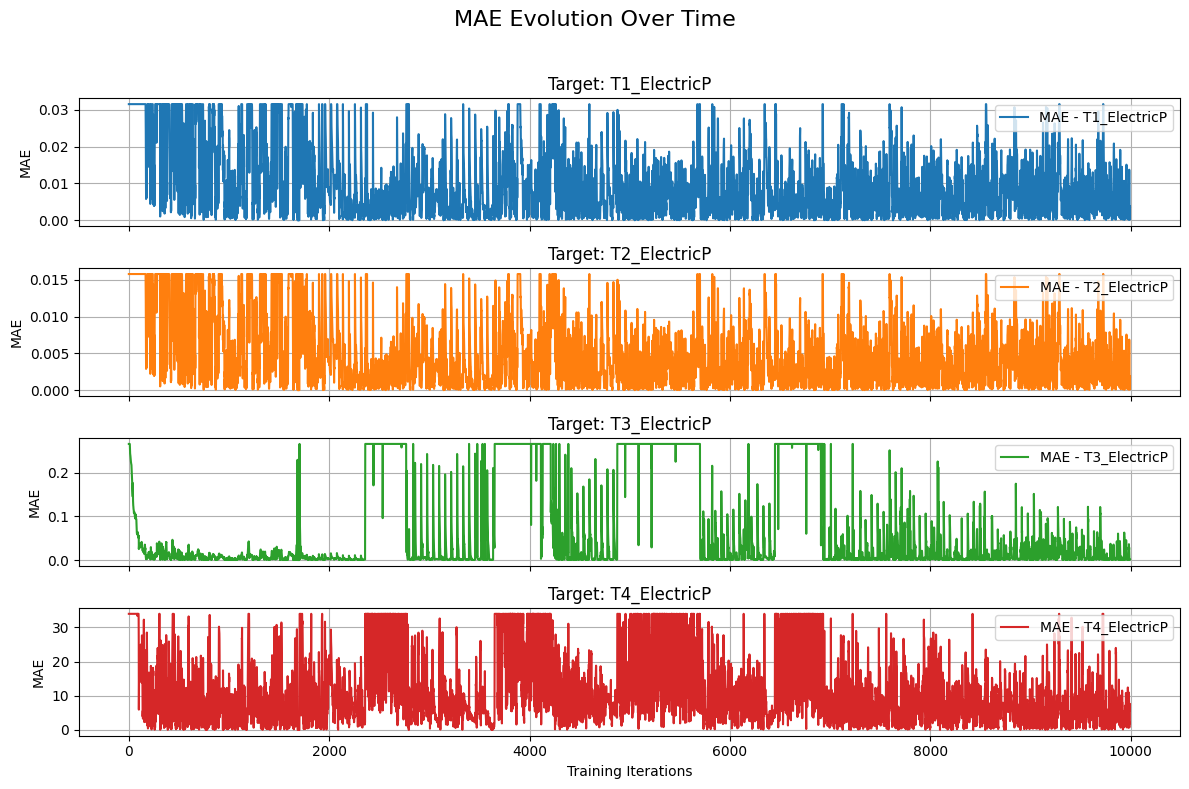

In [17]:
# Call the function after training
plot_mae_evolution_subplots(mae_history_LR, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

# SNARIMAX

In [18]:
# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

In [19]:
def process_and_train_row_snarimax(index, row, models, previous_data, processed_indices, results, mae_history, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP']):
    """
    Process each row: apply cleaning, transformations, and train the model.

    Parameters:
    index (Timestamp): Index of the row.
    row (pd.Series): The data row to be processed.
    models (dict): Dictionary of models for each target.
    previous_data (list): List to store the previous rows for lag feature creation.
    processed_indices (set): Set of indices that have been processed previously.
    results (dict): Dictionary to store the results.
    mae_history (dict): Dictionary to store MAE history.
    targets (list): List of target columns.
    """
    # Cleaning the data
    row = prepare_datetime_index(row)
    row = clean_data(index, row, processed_indices)
    if row is None:
        return

    # Clean negative values for numeric columns
    row = clean_negative_values_numeric_row(row)

    # Feature engineering
    row = create_features_row(row)
    row = create_compressor_state_features_row(row)
    row = create_lag_features_row(row, previous_data)

    # Transform data
    row = scale_and_transform_data(row)

    # Exclude columns not relevant to prediction
    exclude_columns = ['temps']
    features = [col for col in row.index if col not in exclude_columns + targets]

    # Train and predict for each target
    for target in targets:
        y_true = row[target]

        # Handle SNARIMAX separately
        if isinstance(models[target], time_series.SNARIMAX):
            # Forecast for the next time step
            y_pred = models[target].forecast(horizon=1)[0]  # Forecast one step ahead
            models[target].learn_one(y=y_true)  # Learn the true value
        else:
            # Train and predict for standard regression models
            x = {feature: row[feature] for feature in features}
            y_pred = models[target].predict_one(x)
            models[target].learn_one(x, y_true)

        # Inverse transform and clip predictions
        y_true_original = np.expm1(y_true)
        y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)

        # Update MAE metric
        metric = utils.Rolling(metrics.MAE(), 50)
        metric.update(y_true_original, y_pred_original)
        mae = metric.get()
        mae_history[target].append(mae)

        # Print the results for each row
        print(f"Index: {index}, Target: {target}, True: {y_true_original:.4f}, Predicted: {y_pred_original:.4f}, MAE: {mae:.4f}")


        # Store the results
        results[target]['timestamp'].append(index)
        results[target]['actual'].append(y_true_original)
        results[target]['predicted'].append(y_pred_original)

    # Add the row to previous data for lag features
    previous_data.append(row)


In [20]:
# Simulate streaming data processing
for index, row in data.tail(5000).iterrows():
  process_and_train_row_snarimax(index, row, snarimax_models, previous_data, processed_indices, results, mae_history_snarimax)

Index: 740860, Target: T1_ElectricP, True: 1.0000, Predicted: 0.0000, MAE: 1.0000
Index: 740860, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 740860, Target: T3_ElectricP, True: 406.9998, Predicted: 0.0000, MAE: 406.9998
Index: 740860, Target: T4_ElectricP, True: 174.9999, Predicted: 0.0000, MAE: 174.9999
Index: 740861, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 740861, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 740861, Target: T3_ElectricP, True: 406.9998, Predicted: 406.9998, MAE: 0.0000
Index: 740861, Target: T4_ElectricP, True: 171.9999, Predicted: 174.9999, MAE: 3.0000
Index: 740862, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 740862, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 740862, Target: T3_ElectricP, True: 484.9998, Predicted: 406.9998, MAE: 78.0000
Index: 740862, Target: T4_ElectricP, True: 199.9999, Predicted: 171.9404, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 741563, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741563, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741563, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 741563, Target: T4_ElectricP, True: 518.9998, Predicted: 519.9629, MAE: 0.9631
Index: 741564, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741564, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741564, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741564, Target: T4_ElectricP, True: 504.9998, Predicted: 526.7850, MAE: 21.7852
Index: 741565, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741565, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741565, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741565, Target: T4_ElectricP, True: 454.9998, Predicted: 511.2933, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 741569, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741569, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741569, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741569, Target: T4_ElectricP, True: 437.9998, Predicted: 445.2098, MAE: 7.2100
Index: 741570, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741570, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741570, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 741570, Target: T4_ElectricP, True: 425.9998, Predicted: 443.9283, MAE: 17.9285
Index: 741571, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741571, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741571, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 741571, Target: T4_ElectricP, True: 408.9998, Predicted: 4

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 741572, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741572, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741572, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741572, Target: T4_ElectricP, True: 412.9998, Predicted: 409.0081, MAE: 3.9917
Index: 741573, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741573, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741573, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 741573, Target: T4_ElectricP, True: 412.9998, Predicted: 418.5492, MAE: 5.5494
Index: 741574, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741574, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741574, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741574, Target: T4_ElectricP, True: 410.9998, Predicted: 419.3339, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 741575, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741575, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741575, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741575, Target: T4_ElectricP, True: 413.9998, Predicted: 414.6056, MAE: 0.6058
Index: 741576, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741576, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741576, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741576, Target: T4_ElectricP, True: 432.9998, Predicted: 418.9360, MAE: 14.0639
Index: 741577, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 741577, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741577, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 741577, Target: T4_ElectricP, True: 443.9998, Predicted: 442.7473, MAE: 1.2525
Ind

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742321, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742321, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742321, Target: T3_ElectricP, True: 401.9998, Predicted: 1000000.0000, MAE: 999598.0002
Index: 742321, Target: T4_ElectricP, True: 209.9999, Predicted: 157.1456, MAE: 52.8543
Index: 742322, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742322, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742322, Target: T3_ElectricP, True: 408.9998, Predicted: 0.0000, MAE: 408.9998
Index: 742322, Target: T4_ElectricP, True: 178.9999, Predicted: 276.2099, MAE: 97.2100
Index: 742323, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742323, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742323, Target: T3_ElectricP, True: 458.9998, Predicted: 0.0000, MAE: 458.9998
Index: 742323, Target: T4_ElectricP, True: 180.9999, Predicted: 163

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742326, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742326, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742326, Target: T3_ElectricP, True: 430.9998, Predicted: 0.0000, MAE: 430.9998
Index: 742326, Target: T4_ElectricP, True: 178.9999, Predicted: 164.6606, MAE: 14.3393
Index: 742327, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742327, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742327, Target: T3_ElectricP, True: 471.9998, Predicted: 0.0000, MAE: 471.9998
Index: 742327, Target: T4_ElectricP, True: 221.9999, Predicted: 172.1723, MAE: 49.8276
Index: 742328, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742328, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742328, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742328, Target: T4_ElectricP, True: 214.9999, Predicted: 217

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742330, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742330, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742330, Target: T3_ElectricP, True: 428.9998, Predicted: 0.0000, MAE: 428.9998
Index: 742330, Target: T4_ElectricP, True: 182.9999, Predicted: 171.4704, MAE: 11.5295
Index: 742331, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742331, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742331, Target: T3_ElectricP, True: 480.9998, Predicted: 0.0000, MAE: 480.9998
Index: 742331, Target: T4_ElectricP, True: 215.9999, Predicted: 179.8454, MAE: 36.1545
Index: 742332, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742332, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742332, Target: T3_ElectricP, True: 468.9998, Predicted: 1000000.0000, MAE: 999531.0002
Index: 742332, Target: T4_ElectricP, True: 214.9999, Predicted: 200

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742334, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742334, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742334, Target: T3_ElectricP, True: 391.9998, Predicted: 1000000.0000, MAE: 999608.0002
Index: 742334, Target: T4_ElectricP, True: 161.9999, Predicted: 212.9209, MAE: 50.9210
Index: 742335, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742335, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742335, Target: T3_ElectricP, True: 390.9998, Predicted: 0.0000, MAE: 390.9998
Index: 742335, Target: T4_ElectricP, True: 177.9999, Predicted: 161.0963, MAE: 16.9036


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742336, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742336, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742336, Target: T3_ElectricP, True: 411.9998, Predicted: 0.0000, MAE: 411.9998
Index: 742336, Target: T4_ElectricP, True: 177.9999, Predicted: 180.1786, MAE: 2.1787
Index: 742337, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742337, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742337, Target: T3_ElectricP, True: 404.9998, Predicted: 0.0000, MAE: 404.9998
Index: 742337, Target: T4_ElectricP, True: 178.9999, Predicted: 180.4601, MAE: 1.4602
Index: 742338, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742338, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742338, Target: T3_ElectricP, True: 400.9998, Predicted: 1000000.0000, MAE: 999599.0002
Index: 742338, Target: T4_ElectricP, True: 177.9999, Predicted: 177.0

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742340, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742340, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742340, Target: T3_ElectricP, True: 393.9998, Predicted: 0.0000, MAE: 393.9998
Index: 742340, Target: T4_ElectricP, True: 162.9999, Predicted: 160.9657, MAE: 2.0342
Index: 742341, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742341, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742341, Target: T3_ElectricP, True: 421.9998, Predicted: 0.0000, MAE: 421.9998
Index: 742341, Target: T4_ElectricP, True: 187.9999, Predicted: 164.0908, MAE: 23.9091
Index: 742342, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742342, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742342, Target: T3_ElectricP, True: 417.9998, Predicted: 1000000.0000, MAE: 999582.0002
Index: 742342, Target: T4_ElectricP, True: 188.9999, Predicted: 183.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742344, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742344, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742344, Target: T3_ElectricP, True: 471.9998, Predicted: 1000000.0000, MAE: 999528.0002
Index: 742344, Target: T4_ElectricP, True: 213.9999, Predicted: 203.1872, MAE: 10.8127
Index: 742345, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742345, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742345, Target: T3_ElectricP, True: 458.9998, Predicted: 1000000.0000, MAE: 999541.0002
Index: 742345, Target: T4_ElectricP, True: 212.9999, Predicted: 208.2250, MAE: 4.7749


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742346, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742346, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742346, Target: T3_ElectricP, True: 435.9998, Predicted: 1000000.0000, MAE: 999564.0002
Index: 742346, Target: T4_ElectricP, True: 211.9999, Predicted: 209.7277, MAE: 2.2722
Index: 742347, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742347, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742347, Target: T3_ElectricP, True: 426.9998, Predicted: 0.0000, MAE: 426.9998
Index: 742347, Target: T4_ElectricP, True: 206.9999, Predicted: 211.2285, MAE: 4.2286


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742348, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742348, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742348, Target: T3_ElectricP, True: 427.9998, Predicted: 0.0000, MAE: 427.9998
Index: 742348, Target: T4_ElectricP, True: 189.9999, Predicted: 207.3673, MAE: 17.3674
Index: 742349, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742349, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742349, Target: T3_ElectricP, True: 429.9998, Predicted: 0.0000, MAE: 429.9998
Index: 742349, Target: T4_ElectricP, True: 188.9999, Predicted: 191.4460, MAE: 2.4460
Index: 742350, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742350, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742350, Target: T3_ElectricP, True: 479.9998, Predicted: 0.0000, MAE: 479.9998
Index: 742350, Target: T4_ElectricP, True: 206.9999, Predicted: 190.7755, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742352, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742352, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742352, Target: T3_ElectricP, True: 468.9998, Predicted: 1000000.0000, MAE: 999531.0002
Index: 742352, Target: T4_ElectricP, True: 211.9999, Predicted: 208.8149, MAE: 3.1851
Index: 742353, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742353, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742353, Target: T3_ElectricP, True: 465.9998, Predicted: 1000000.0000, MAE: 999534.0002
Index: 742353, Target: T4_ElectricP, True: 212.9999, Predicted: 209.6201, MAE: 3.3798


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742354, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742354, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742354, Target: T3_ElectricP, True: 460.9998, Predicted: 0.0000, MAE: 460.9998
Index: 742354, Target: T4_ElectricP, True: 213.9999, Predicted: 212.0226, MAE: 1.9773
Index: 742355, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742355, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742355, Target: T3_ElectricP, True: 449.9998, Predicted: 0.0000, MAE: 449.9998
Index: 742355, Target: T4_ElectricP, True: 234.9999, Predicted: 213.6702, MAE: 21.3296
Index: 742356, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742356, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742356, Target: T3_ElectricP, True: 469.9998, Predicted: 0.0000, MAE: 469.9998
Index: 742356, Target: T4_ElectricP, True: 220.9999, Predicted: 234.2164, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742358, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742358, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742358, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742358, Target: T4_ElectricP, True: 212.9999, Predicted: 222.1337, MAE: 9.1338
Index: 742359, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742359, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742359, Target: T3_ElectricP, True: 432.9998, Predicted: 1000000.0000, MAE: 999567.0002
Index: 742359, Target: T4_ElectricP, True: 172.9999, Predicted: 215.0311, MAE: 42.0311


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742360, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742360, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742360, Target: T3_ElectricP, True: 438.9998, Predicted: 0.0000, MAE: 438.9998
Index: 742360, Target: T4_ElectricP, True: 190.9999, Predicted: 174.6563, MAE: 16.3436
Index: 742361, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742361, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742361, Target: T3_ElectricP, True: 481.9998, Predicted: 0.0000, MAE: 481.9998
Index: 742361, Target: T4_ElectricP, True: 211.9999, Predicted: 192.6672, MAE: 19.3327
Index: 742362, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742362, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742362, Target: T3_ElectricP, True: 486.9998, Predicted: 1000000.0000, MAE: 999513.0002
Index: 742362, Target: T4_ElectricP, True: 212.9999, Predicted: 208

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742363, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742363, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742363, Target: T3_ElectricP, True: 476.9998, Predicted: 1000000.0000, MAE: 999523.0002
Index: 742363, Target: T4_ElectricP, True: 212.9999, Predicted: 206.9104, MAE: 6.0895
Index: 742364, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742364, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742364, Target: T3_ElectricP, True: 456.9998, Predicted: 1000000.0000, MAE: 999543.0002
Index: 742364, Target: T4_ElectricP, True: 211.9999, Predicted: 210.2013, MAE: 1.7986
Index: 742365, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742365, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742365, Target: T3_ElectricP, True: 450.9998, Predicted: 0.0000, MAE: 450.9998
Index: 742365, Target: T4_ElectricP, True: 210.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742369, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742369, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742369, Target: T3_ElectricP, True: 486.9998, Predicted: 1000000.0000, MAE: 999513.0002
Index: 742369, Target: T4_ElectricP, True: 245.9999, Predicted: 239.3698, MAE: 6.6301
Index: 742370, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742370, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742370, Target: T3_ElectricP, True: 475.9998, Predicted: 1000000.0000, MAE: 999524.0002
Index: 742370, Target: T4_ElectricP, True: 210.9999, Predicted: 241.6676, MAE: 30.6677
Index: 742371, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742371, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742371, Target: T3_ElectricP, True: 455.9998, Predicted: 0.0000, MAE: 455.9998
Index: 742371, Target: T4_ElectricP, True: 208.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742375, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742375, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742375, Target: T3_ElectricP, True: 472.9998, Predicted: 1000000.0000, MAE: 999527.0002
Index: 742375, Target: T4_ElectricP, True: 206.9999, Predicted: 206.2016, MAE: 0.7983
Index: 742376, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742376, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742376, Target: T3_ElectricP, True: 424.9998, Predicted: 1000000.0000, MAE: 999575.0002
Index: 742376, Target: T4_ElectricP, True: 200.9999, Predicted: 202.9555, MAE: 1.9556
Index: 742377, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742377, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742377, Target: T3_ElectricP, True: 457.9998, Predicted: 0.0000, MAE: 457.9998
Index: 742377, Target: T4_ElectricP, True: 212.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742382, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742382, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742382, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742382, Target: T4_ElectricP, True: 212.9999, Predicted: 214.2306, MAE: 1.2307
Index: 742383, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742383, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742383, Target: T3_ElectricP, True: 430.9998, Predicted: 0.0000, MAE: 430.9998
Index: 742383, Target: T4_ElectricP, True: 177.9999, Predicted: 213.1751, MAE: 35.1752
Index: 742384, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742384, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742384, Target: T3_ElectricP, True: 437.9998, Predicted: 0.0000, MAE: 437.9998
Index: 742384, Target: T4_ElectricP, True: 194.9999, Predicted: 178.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742385, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742385, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742385, Target: T3_ElectricP, True: 436.9998, Predicted: 0.0000, MAE: 436.9998
Index: 742385, Target: T4_ElectricP, True: 195.9999, Predicted: 198.6030, MAE: 2.6031
Index: 742386, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742386, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742386, Target: T3_ElectricP, True: 435.9998, Predicted: 0.0000, MAE: 435.9998
Index: 742386, Target: T4_ElectricP, True: 196.9999, Predicted: 195.1303, MAE: 1.8696
Index: 742387, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742387, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742387, Target: T3_ElectricP, True: 391.9998, Predicted: 1000000.0000, MAE: 999608.0002
Index: 742387, Target: T4_ElectricP, True: 163.9999, Predicted: 195.5

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742388, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742388, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742388, Target: T3_ElectricP, True: 402.9998, Predicted: 0.0000, MAE: 402.9998
Index: 742388, Target: T4_ElectricP, True: 169.9999, Predicted: 167.6861, MAE: 2.3138
Index: 742389, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742389, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742389, Target: T3_ElectricP, True: 475.9998, Predicted: 0.0000, MAE: 475.9998
Index: 742389, Target: T4_ElectricP, True: 212.9999, Predicted: 174.6118, MAE: 38.3881
Index: 742390, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742390, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742390, Target: T3_ElectricP, True: 457.9998, Predicted: 1000000.0000, MAE: 999542.0002
Index: 742390, Target: T4_ElectricP, True: 212.9999, Predicted: 209.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742392, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742392, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742392, Target: T3_ElectricP, True: 477.9998, Predicted: 0.0000, MAE: 477.9998
Index: 742392, Target: T4_ElectricP, True: 214.9999, Predicted: 171.5263, MAE: 43.4736
Index: 742393, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742393, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742393, Target: T3_ElectricP, True: 479.9998, Predicted: 1000000.0000, MAE: 999520.0002
Index: 742393, Target: T4_ElectricP, True: 231.9999, Predicted: 212.3692, MAE: 19.6307
Index: 742394, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742394, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742394, Target: T3_ElectricP, True: 472.9998, Predicted: 1000000.0000, MAE: 999527.0002
Index: 742394, Target: T4_ElectricP, True: 219.9999, Predi

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742395, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742395, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742395, Target: T3_ElectricP, True: 468.9998, Predicted: 1000000.0000, MAE: 999531.0002
Index: 742395, Target: T4_ElectricP, True: 212.9999, Predicted: 209.4650, MAE: 3.5349
Index: 742396, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742396, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742396, Target: T3_ElectricP, True: 423.9998, Predicted: 0.0000, MAE: 423.9998
Index: 742396, Target: T4_ElectricP, True: 195.9999, Predicted: 217.1534, MAE: 21.1535
Index: 742397, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742397, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742397, Target: T3_ElectricP, True: 428.9998, Predicted: 0.0000, MAE: 428.9998
Index: 742397, Target: T4_ElectricP, True: 194.9999, Predicted: 203.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742401, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742401, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742401, Target: T3_ElectricP, True: 481.9998, Predicted: 0.0000, MAE: 481.9998
Index: 742401, Target: T4_ElectricP, True: 208.9999, Predicted: 173.7909, MAE: 35.2090
Index: 742402, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742402, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742402, Target: T3_ElectricP, True: 458.9998, Predicted: 1000000.0000, MAE: 999541.0002
Index: 742402, Target: T4_ElectricP, True: 209.9999, Predicted: 207.9046, MAE: 2.0953
Index: 742403, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742403, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742403, Target: T3_ElectricP, True: 455.9998, Predicted: 0.0000, MAE: 455.9998
Index: 742403, Target: T4_ElectricP, True: 204.9999, Predicted: 193.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742404, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742404, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742404, Target: T3_ElectricP, True: 461.9998, Predicted: 1000000.0000, MAE: 999538.0002
Index: 742404, Target: T4_ElectricP, True: 197.9999, Predicted: 200.1868, MAE: 2.1869
Index: 742405, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742405, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742405, Target: T3_ElectricP, True: 458.9998, Predicted: 0.0000, MAE: 458.9998
Index: 742405, Target: T4_ElectricP, True: 197.9999, Predicted: 200.8962, MAE: 2.8963
Index: 742406, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742406, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742406, Target: T3_ElectricP, True: 457.9998, Predicted: 0.0000, MAE: 457.9998
Index: 742406, Target: T4_ElectricP, True: 197.9999, Predicted: 202.2

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742414, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742414, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742414, Target: T3_ElectricP, True: 476.9998, Predicted: 1000000.0000, MAE: 999523.0002
Index: 742414, Target: T4_ElectricP, True: 209.9999, Predicted: 194.8629, MAE: 15.1370
Index: 742415, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742415, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742415, Target: T3_ElectricP, True: 399.9998, Predicted: 1000000.0000, MAE: 999600.0002
Index: 742415, Target: T4_ElectricP, True: 168.9999, Predicted: 195.6529, MAE: 26.6530
Index: 742416, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742416, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742416, Target: T3_ElectricP, True: 451.9998, Predicted: 0.0000, MAE: 451.9998
Index: 742416, Target: T4_ElectricP, True: 208.9999, Predi

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742417, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742417, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742417, Target: T3_ElectricP, True: 468.9998, Predicted: 0.0000, MAE: 468.9998
Index: 742417, Target: T4_ElectricP, True: 231.9999, Predicted: 209.8370, MAE: 22.1629
Index: 742418, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742418, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742418, Target: T3_ElectricP, True: 467.9998, Predicted: 1000000.0000, MAE: 999532.0002
Index: 742418, Target: T4_ElectricP, True: 228.9999, Predicted: 201.1467, MAE: 27.8532
Index: 742419, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742419, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742419, Target: T3_ElectricP, True: 478.9998, Predicted: 1000000.0000, MAE: 999521.0002
Index: 742419, Target: T4_ElectricP, True: 226.9999, Predi

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742420, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742420, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742420, Target: T3_ElectricP, True: 480.9998, Predicted: 1000000.0000, MAE: 999519.0002
Index: 742420, Target: T4_ElectricP, True: 214.9999, Predicted: 220.4708, MAE: 5.4709
Index: 742421, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742421, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742421, Target: T3_ElectricP, True: 410.9998, Predicted: 1000000.0000, MAE: 999589.0002
Index: 742421, Target: T4_ElectricP, True: 170.9999, Predicted: 219.3542, MAE: 48.3542
Index: 742422, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742422, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742422, Target: T3_ElectricP, True: 431.9998, Predicted: 0.0000, MAE: 431.9998
Index: 742422, Target: T4_ElectricP, True: 170.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742423, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742423, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742423, Target: T3_ElectricP, True: 473.9998, Predicted: 0.0000, MAE: 473.9998
Index: 742423, Target: T4_ElectricP, True: 197.9999, Predicted: 191.6642, MAE: 6.3357
Index: 742424, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742424, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742424, Target: T3_ElectricP, True: 455.9998, Predicted: 1000000.0000, MAE: 999544.0002
Index: 742424, Target: T4_ElectricP, True: 198.9999, Predicted: 205.1846, MAE: 6.1847
Index: 742425, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742425, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742425, Target: T3_ElectricP, True: 432.9998, Predicted: 1000000.0000, MAE: 999567.0002
Index: 742425, Target: T4_ElectricP, True: 194.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742426, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742426, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742426, Target: T3_ElectricP, True: 414.9998, Predicted: 0.0000, MAE: 414.9998
Index: 742426, Target: T4_ElectricP, True: 177.9999, Predicted: 192.8456, MAE: 14.8457
Index: 742427, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742427, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742427, Target: T3_ElectricP, True: 433.9998, Predicted: 0.0000, MAE: 433.9998
Index: 742427, Target: T4_ElectricP, True: 180.9999, Predicted: 181.0731, MAE: 0.0732
Index: 742428, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742428, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742428, Target: T3_ElectricP, True: 461.9998, Predicted: 0.0000, MAE: 461.9998
Index: 742428, Target: T4_ElectricP, True: 199.9999, Predicted: 188.8730, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742430, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742430, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742430, Target: T3_ElectricP, True: 444.9998, Predicted: 1000000.0000, MAE: 999555.0002
Index: 742430, Target: T4_ElectricP, True: 196.9999, Predicted: 193.0592, MAE: 3.9408
Index: 742431, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742431, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742431, Target: T3_ElectricP, True: 442.9998, Predicted: 0.0000, MAE: 442.9998
Index: 742431, Target: T4_ElectricP, True: 195.9999, Predicted: 194.8549, MAE: 1.1450
Index: 742432, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742432, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742432, Target: T3_ElectricP, True: 470.9998, Predicted: 0.0000, MAE: 470.9998
Index: 742432, Target: T4_ElectricP, True: 239.9999, Predicted: 197.5

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742436, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742436, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742436, Target: T3_ElectricP, True: 459.9998, Predicted: 0.0000, MAE: 459.9998
Index: 742436, Target: T4_ElectricP, True: 175.9999, Predicted: 186.6098, MAE: 10.6099
Index: 742437, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742437, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742437, Target: T3_ElectricP, True: 460.9998, Predicted: 1000000.0000, MAE: 999539.0002
Index: 742437, Target: T4_ElectricP, True: 182.9999, Predicted: 195.0344, MAE: 12.0345
Index: 742438, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742438, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742438, Target: T3_ElectricP, True: 451.9998, Predicted: 1000000.0000, MAE: 999548.0002
Index: 742438, Target: T4_ElectricP, True: 186.9999, Predi

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742439, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742439, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742439, Target: T3_ElectricP, True: 454.9998, Predicted: 1000000.0000, MAE: 999545.0002
Index: 742439, Target: T4_ElectricP, True: 189.9999, Predicted: 187.1374, MAE: 2.8625
Index: 742440, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742440, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742440, Target: T3_ElectricP, True: 421.9998, Predicted: 0.0000, MAE: 421.9998
Index: 742440, Target: T4_ElectricP, True: 177.9999, Predicted: 187.8006, MAE: 9.8007
Index: 742441, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742441, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742441, Target: T3_ElectricP, True: 453.9998, Predicted: 0.0000, MAE: 453.9998
Index: 742441, Target: T4_ElectricP, True: 199.9999, Predicted: 175.9

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742445, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742445, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742445, Target: T3_ElectricP, True: 464.9998, Predicted: 0.0000, MAE: 464.9998
Index: 742445, Target: T4_ElectricP, True: 196.9999, Predicted: 199.4485, MAE: 2.4486
Index: 742446, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742446, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742446, Target: T3_ElectricP, True: 471.9998, Predicted: 1000000.0000, MAE: 999528.0002
Index: 742446, Target: T4_ElectricP, True: 200.9999, Predicted: 190.2239, MAE: 10.7760
Index: 742447, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742447, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742447, Target: T3_ElectricP, True: 473.9998, Predicted: 1000000.0000, MAE: 999526.0002
Index: 742447, Target: T4_ElectricP, True: 202.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742448, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742448, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742448, Target: T3_ElectricP, True: 414.9998, Predicted: 1000000.0000, MAE: 999585.0002
Index: 742448, Target: T4_ElectricP, True: 175.9999, Predicted: 199.3194, MAE: 23.3194
Index: 742449, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742449, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742449, Target: T3_ElectricP, True: 409.9998, Predicted: 0.0000, MAE: 409.9998
Index: 742449, Target: T4_ElectricP, True: 174.9999, Predicted: 180.3919, MAE: 5.3920
Index: 742450, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742450, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742450, Target: T3_ElectricP, True: 404.9998, Predicted: 0.0000, MAE: 404.9998
Index: 742450, Target: T4_ElectricP, True: 174.9999, Predicted: 185.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742454, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742454, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742454, Target: T3_ElectricP, True: 455.9998, Predicted: 1000000.0000, MAE: 999544.0002
Index: 742454, Target: T4_ElectricP, True: 211.9999, Predicted: 185.5851, MAE: 26.4148
Index: 742455, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742455, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742455, Target: T3_ElectricP, True: 467.9998, Predicted: 1000000.0000, MAE: 999532.0002
Index: 742455, Target: T4_ElectricP, True: 214.9999, Predicted: 204.8708, MAE: 10.1291
Index: 742456, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742456, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742456, Target: T3_ElectricP, True: 474.9998, Predicted: 1000000.0000, MAE: 999525.0002
Index: 742456, Target: T4_ElectricP, True: 214.99

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742457, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742457, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742457, Target: T3_ElectricP, True: 475.9998, Predicted: 1000000.0000, MAE: 999524.0002
Index: 742457, Target: T4_ElectricP, True: 214.9999, Predicted: 211.7284, MAE: 3.2715
Index: 742458, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742458, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742458, Target: T3_ElectricP, True: 475.9998, Predicted: 1000000.0000, MAE: 999524.0002
Index: 742458, Target: T4_ElectricP, True: 224.9999, Predicted: 215.0153, MAE: 9.9846
Index: 742459, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742459, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742459, Target: T3_ElectricP, True: 476.9998, Predicted: 0.0000, MAE: 476.9998
Index: 742459, Target: T4_ElectricP, True: 250.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742463, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742463, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742463, Target: T3_ElectricP, True: 478.9998, Predicted: 0.0000, MAE: 478.9998
Index: 742463, Target: T4_ElectricP, True: 260.9999, Predicted: 261.1690, MAE: 0.1691
Index: 742464, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742464, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742464, Target: T3_ElectricP, True: 482.9998, Predicted: 0.0000, MAE: 482.9998
Index: 742464, Target: T4_ElectricP, True: 253.9999, Predicted: 263.5832, MAE: 9.5833
Index: 742465, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742465, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742465, Target: T3_ElectricP, True: 483.9998, Predicted: 0.0000, MAE: 483.9998
Index: 742465, Target: T4_ElectricP, True: 256.9999, Predicted: 257.8678, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742472, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742472, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742472, Target: T3_ElectricP, True: 487.9998, Predicted: 1000000.0000, MAE: 999512.0002
Index: 742472, Target: T4_ElectricP, True: 249.9999, Predicted: 260.0552, MAE: 10.0553
Index: 742473, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742473, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742473, Target: T3_ElectricP, True: 481.9998, Predicted: 0.0000, MAE: 481.9998
Index: 742473, Target: T4_ElectricP, True: 243.9999, Predicted: 252.7622, MAE: 8.7623
Index: 742474, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742474, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742474, Target: T3_ElectricP, True: 477.9998, Predicted: 0.0000, MAE: 477.9998
Index: 742474, Target: T4_ElectricP, True: 214.9999, Predicted: 248.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742479, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742479, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742479, Target: T3_ElectricP, True: 492.9998, Predicted: 1000000.0000, MAE: 999507.0002
Index: 742479, Target: T4_ElectricP, True: 216.9999, Predicted: 233.4863, MAE: 16.4864
Index: 742480, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742480, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742480, Target: T3_ElectricP, True: 491.9998, Predicted: 1000000.0000, MAE: 999508.0002
Index: 742480, Target: T4_ElectricP, True: 216.9999, Predicted: 210.9359, MAE: 6.0640


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742481, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742481, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742481, Target: T3_ElectricP, True: 485.9998, Predicted: 0.0000, MAE: 485.9998
Index: 742481, Target: T4_ElectricP, True: 216.9999, Predicted: 218.9341, MAE: 1.9342
Index: 742482, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742482, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742482, Target: T3_ElectricP, True: 468.9998, Predicted: 0.0000, MAE: 468.9998
Index: 742482, Target: T4_ElectricP, True: 208.9999, Predicted: 217.9731, MAE: 8.9732
Index: 742483, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742483, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742483, Target: T3_ElectricP, True: 394.9998, Predicted: 0.0000, MAE: 394.9998
Index: 742483, Target: T4_ElectricP, True: 170.9999, Predicted: 210.1274, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742487, Target: T4_ElectricP, True: 175.9999, Predicted: 175.1928, MAE: 0.8072
Index: 742488, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742488, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742488, Target: T3_ElectricP, True: 430.9998, Predicted: 1000000.0000, MAE: 999569.0002
Index: 742488, Target: T4_ElectricP, True: 175.9999, Predicted: 175.4504, MAE: 0.5496
Index: 742489, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742489, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742489, Target: T3_ElectricP, True: 436.9998, Predicted: 1000000.0000, MAE: 999563.0002
Index: 742489, Target: T4_ElectricP, True: 200.9999, Predicted: 175.0859, MAE: 25.9140
Index: 742490, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742490, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742490, Target: T3_ElectricP, True: 386.9998, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742491, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742491, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742491, Target: T3_ElectricP, True: 458.9998, Predicted: 0.0000, MAE: 458.9998
Index: 742491, Target: T4_ElectricP, True: 209.9999, Predicted: 170.0101, MAE: 39.9898
Index: 742492, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742492, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742492, Target: T3_ElectricP, True: 480.9998, Predicted: 1000000.0000, MAE: 999519.0002
Index: 742492, Target: T4_ElectricP, True: 217.9999, Predicted: 190.2191, MAE: 27.7808


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742493, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742493, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742493, Target: T3_ElectricP, True: 475.9998, Predicted: 1000000.0000, MAE: 999524.0002
Index: 742493, Target: T4_ElectricP, True: 217.9999, Predicted: 198.0915, MAE: 19.9084
Index: 742494, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742494, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742494, Target: T3_ElectricP, True: 481.9998, Predicted: 1000000.0000, MAE: 999518.0002
Index: 742494, Target: T4_ElectricP, True: 221.9999, Predicted: 212.2874, MAE: 9.7125


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742495, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742495, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742495, Target: T3_ElectricP, True: 480.9998, Predicted: 1000000.0000, MAE: 999519.0002
Index: 742495, Target: T4_ElectricP, True: 215.9999, Predicted: 220.8676, MAE: 4.8677
Index: 742496, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742496, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742496, Target: T3_ElectricP, True: 406.9998, Predicted: 0.0000, MAE: 406.9998
Index: 742496, Target: T4_ElectricP, True: 172.9999, Predicted: 218.0171, MAE: 45.0172
Index: 742497, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742497, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742497, Target: T3_ElectricP, True: 409.9998, Predicted: 0.0000, MAE: 409.9998
Index: 742497, Target: T4_ElectricP, True: 166.9999, Predicted: 182.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742501, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742501, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742501, Target: T3_ElectricP, True: 423.9998, Predicted: 0.0000, MAE: 423.9998
Index: 742501, Target: T4_ElectricP, True: 185.9999, Predicted: 167.9632, MAE: 18.0367
Index: 742502, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742502, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742502, Target: T3_ElectricP, True: 441.9998, Predicted: 0.0000, MAE: 441.9998
Index: 742502, Target: T4_ElectricP, True: 187.9999, Predicted: 188.7477, MAE: 0.7477
Index: 742503, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742503, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742503, Target: T3_ElectricP, True: 428.9998, Predicted: 1000000.0000, MAE: 999571.0002
Index: 742503, Target: T4_ElectricP, True: 187.9999, Predicted: 184.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742505, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742505, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742505, Target: T3_ElectricP, True: 478.9998, Predicted: 1000000.0000, MAE: 999521.0002
Index: 742505, Target: T4_ElectricP, True: 214.9999, Predicted: 205.0121, MAE: 9.9878
Index: 742506, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742506, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742506, Target: T3_ElectricP, True: 464.9998, Predicted: 1000000.0000, MAE: 999535.0002
Index: 742506, Target: T4_ElectricP, True: 210.9999, Predicted: 207.3596, MAE: 3.6403


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742507, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742507, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742507, Target: T3_ElectricP, True: 446.9998, Predicted: 1000000.0000, MAE: 999553.0002
Index: 742507, Target: T4_ElectricP, True: 198.9999, Predicted: 211.7087, MAE: 12.7087
Index: 742508, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742508, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742508, Target: T3_ElectricP, True: 460.9998, Predicted: 0.0000, MAE: 460.9998
Index: 742508, Target: T4_ElectricP, True: 199.9999, Predicted: 204.2202, MAE: 4.2203


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742509, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742509, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742509, Target: T3_ElectricP, True: 453.9998, Predicted: 0.0000, MAE: 453.9998
Index: 742509, Target: T4_ElectricP, True: 187.9999, Predicted: 204.4055, MAE: 16.4056
Index: 742510, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742510, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742510, Target: T3_ElectricP, True: 431.9998, Predicted: 0.0000, MAE: 431.9998
Index: 742510, Target: T4_ElectricP, True: 175.9999, Predicted: 192.6526, MAE: 16.6526
Index: 742511, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742511, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742511, Target: T3_ElectricP, True: 435.9998, Predicted: 0.0000, MAE: 435.9998
Index: 742511, Target: T4_ElectricP, True: 177.9999, Predicted: 182.0384, MA

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742515, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742515, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742515, Target: T3_ElectricP, True: 466.9998, Predicted: 1000000.0000, MAE: 999533.0002
Index: 742515, Target: T4_ElectricP, True: 208.9999, Predicted: 187.3346, MAE: 21.6653
Index: 742516, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742516, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742516, Target: T3_ElectricP, True: 395.9998, Predicted: 1000000.0000, MAE: 999604.0002
Index: 742516, Target: T4_ElectricP, True: 168.9999, Predicted: 204.2894, MAE: 35.2895


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742517, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742517, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742517, Target: T3_ElectricP, True: 411.9998, Predicted: 0.0000, MAE: 411.9998
Index: 742517, Target: T4_ElectricP, True: 172.9999, Predicted: 176.5457, MAE: 3.5458
Index: 742518, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742518, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742518, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742518, Target: T4_ElectricP, True: 216.9999, Predicted: 181.8970, MAE: 35.1029
Index: 742519, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742519, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742519, Target: T3_ElectricP, True: 484.9998, Predicted: 1000000.0000, MAE: 999515.0002
Index: 742519, Target: T4_ElectricP, True: 216.9999, Predicted: 201.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742521, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742521, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742521, Target: T3_ElectricP, True: 441.9998, Predicted: 1000000.0000, MAE: 999558.0002
Index: 742521, Target: T4_ElectricP, True: 181.9999, Predicted: 199.4121, MAE: 17.4122
Index: 742522, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742522, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742522, Target: T3_ElectricP, True: 478.9998, Predicted: 0.0000, MAE: 478.9998
Index: 742522, Target: T4_ElectricP, True: 212.9999, Predicted: 190.1716, MAE: 22.8283


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742523, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742523, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742523, Target: T3_ElectricP, True: 457.9998, Predicted: 1000000.0000, MAE: 999542.0002
Index: 742523, Target: T4_ElectricP, True: 215.9999, Predicted: 216.3999, MAE: 0.4000
Index: 742524, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742524, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742524, Target: T3_ElectricP, True: 398.9998, Predicted: 0.0000, MAE: 398.9998
Index: 742524, Target: T4_ElectricP, True: 165.9999, Predicted: 206.6562, MAE: 40.6563
Index: 742525, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742525, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742525, Target: T3_ElectricP, True: 402.9998, Predicted: 0.0000, MAE: 402.9998
Index: 742525, Target: T4_ElectricP, True: 165.9999, Predicted: 174.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742530, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742530, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742530, Target: T3_ElectricP, True: 440.9998, Predicted: 1000000.0000, MAE: 999559.0002
Index: 742530, Target: T4_ElectricP, True: 187.9999, Predicted: 185.1024, MAE: 2.8975
Index: 742531, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742531, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742531, Target: T3_ElectricP, True: 417.9998, Predicted: 1000000.0000, MAE: 999582.0002
Index: 742531, Target: T4_ElectricP, True: 188.9999, Predicted: 185.1788, MAE: 3.8212
Index: 742532, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742532, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742532, Target: T3_ElectricP, True: 428.9998, Predicted: 0.0000, MAE: 428.9998
Index: 742532, Target: T4_ElectricP, True: 189.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742533, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742533, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742533, Target: T3_ElectricP, True: 474.9998, Predicted: 0.0000, MAE: 474.9998
Index: 742533, Target: T4_ElectricP, True: 217.9999, Predicted: 188.9877, MAE: 29.0122
Index: 742534, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742534, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742534, Target: T3_ElectricP, True: 471.9998, Predicted: 1000000.0000, MAE: 999528.0002
Index: 742534, Target: T4_ElectricP, True: 217.9999, Predicted: 213.8063, MAE: 4.1936
Index: 742535, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742535, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742535, Target: T3_ElectricP, True: 450.9998, Predicted: 1000000.0000, MAE: 999549.0002
Index: 742535, Target: T4_ElectricP, True: 202.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742536, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742536, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742536, Target: T3_ElectricP, True: 460.9998, Predicted: 0.0000, MAE: 460.9998
Index: 742536, Target: T4_ElectricP, True: 186.9999, Predicted: 203.0707, MAE: 16.0708
Index: 742537, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742537, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742537, Target: T3_ElectricP, True: 465.9998, Predicted: 0.0000, MAE: 465.9998
Index: 742537, Target: T4_ElectricP, True: 184.9999, Predicted: 194.2430, MAE: 9.2431
Index: 742538, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742538, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742538, Target: T3_ElectricP, True: 430.9998, Predicted: 0.0000, MAE: 430.9998
Index: 742538, Target: T4_ElectricP, True: 182.9999, Predicted: 193.2287, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742545, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742545, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742545, Target: T3_ElectricP, True: 455.9998, Predicted: 1000000.0000, MAE: 999544.0002
Index: 742545, Target: T4_ElectricP, True: 200.9999, Predicted: 199.9388, MAE: 1.0611
Index: 742546, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742546, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742546, Target: T3_ElectricP, True: 484.9998, Predicted: 1000000.0000, MAE: 999515.0002
Index: 742546, Target: T4_ElectricP, True: 229.9999, Predicted: 200.7188, MAE: 29.2811
Index: 742547, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742547, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742547, Target: T3_ElectricP, True: 491.9998, Predicted: 1000000.0000, MAE: 999508.0002
Index: 742547, Target: T4_ElectricP, True: 248.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742549, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742549, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742549, Target: T3_ElectricP, True: 494.9998, Predicted: 1000000.0000, MAE: 999505.0002
Index: 742549, Target: T4_ElectricP, True: 233.9999, Predicted: 226.6973, MAE: 7.3026
Index: 742550, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742550, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742550, Target: T3_ElectricP, True: 494.9998, Predicted: 1000000.0000, MAE: 999505.0002
Index: 742550, Target: T4_ElectricP, True: 231.9999, Predicted: 240.0295, MAE: 8.0296
Index: 742551, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742551, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742551, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742551, Target: T4_ElectricP, True: 230.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742552, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742552, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742552, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742552, Target: T4_ElectricP, True: 231.9999, Predicted: 233.3164, MAE: 1.3165
Index: 742553, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742553, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742553, Target: T3_ElectricP, True: 477.9998, Predicted: 0.0000, MAE: 477.9998
Index: 742553, Target: T4_ElectricP, True: 216.9999, Predicted: 233.9801, MAE: 16.9802
Index: 742554, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742554, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742554, Target: T3_ElectricP, True: 410.9998, Predicted: 0.0000, MAE: 410.9998
Index: 742554, Target: T4_ElectricP, True: 171.9999, Predicted: 217.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742555, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742555, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742555, Target: T3_ElectricP, True: 441.9998, Predicted: 0.0000, MAE: 441.9998
Index: 742555, Target: T4_ElectricP, True: 189.9999, Predicted: 170.3969, MAE: 19.6030
Index: 742556, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742556, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742556, Target: T3_ElectricP, True: 471.9998, Predicted: 0.0000, MAE: 471.9998
Index: 742556, Target: T4_ElectricP, True: 204.9999, Predicted: 206.4417, MAE: 1.4418
Index: 742557, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742557, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742557, Target: T3_ElectricP, True: 453.9998, Predicted: 1000000.0000, MAE: 999546.0002
Index: 742557, Target: T4_ElectricP, True: 205.9999, Predicted: 198.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742558, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742558, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742558, Target: T3_ElectricP, True: 421.9998, Predicted: 1000000.0000, MAE: 999578.0002
Index: 742558, Target: T4_ElectricP, True: 189.9999, Predicted: 199.3647, MAE: 9.3648
Index: 742559, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742559, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742559, Target: T3_ElectricP, True: 478.9998, Predicted: 0.0000, MAE: 478.9998
Index: 742559, Target: T4_ElectricP, True: 216.9999, Predicted: 188.7774, MAE: 28.2225
Index: 742560, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742560, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742560, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742560, Target: T4_ElectricP, True: 214.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742563, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742563, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742563, Target: T3_ElectricP, True: 491.9998, Predicted: 1000000.0000, MAE: 999508.0002
Index: 742563, Target: T4_ElectricP, True: 291.9999, Predicted: 301.4191, MAE: 9.4192
Index: 742564, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742564, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742564, Target: T3_ElectricP, True: 491.9998, Predicted: 1000000.0000, MAE: 999508.0002
Index: 742564, Target: T4_ElectricP, True: 283.9999, Predicted: 272.7238, MAE: 11.2761
Index: 742565, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742565, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742565, Target: T3_ElectricP, True: 495.9998, Predicted: 0.0000, MAE: 495.9998
Index: 742565, Target: T4_ElectricP, True: 282.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742566, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742566, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742566, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742566, Target: T4_ElectricP, True: 280.9999, Predicted: 289.9809, MAE: 8.9810
Index: 742567, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742567, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742567, Target: T3_ElectricP, True: 490.9998, Predicted: 1000000.0000, MAE: 999509.0002
Index: 742567, Target: T4_ElectricP, True: 216.9999, Predicted: 284.6587, MAE: 67.6588
Index: 742568, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742568, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742568, Target: T3_ElectricP, True: 417.9998, Predicted: 0.0000, MAE: 417.9998
Index: 742568, Target: T4_ElectricP, True: 166.9999, Predicted: 217.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742569, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742569, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742569, Target: T3_ElectricP, True: 435.9998, Predicted: 0.0000, MAE: 435.9998
Index: 742569, Target: T4_ElectricP, True: 185.9999, Predicted: 156.7921, MAE: 29.2078
Index: 742570, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742570, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742570, Target: T3_ElectricP, True: 443.9998, Predicted: 0.0000, MAE: 443.9998
Index: 742570, Target: T4_ElectricP, True: 190.9999, Predicted: 205.1270, MAE: 14.1271
Index: 742571, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742571, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742571, Target: T3_ElectricP, True: 465.9998, Predicted: 0.0000, MAE: 465.9998
Index: 742571, Target: T4_ElectricP, True: 213.9999, Predicted: 177.8429, MA

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742575, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742575, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742575, Target: T3_ElectricP, True: 473.9998, Predicted: 1000000.0000, MAE: 999526.0002
Index: 742575, Target: T4_ElectricP, True: 223.9999, Predicted: 237.7918, MAE: 13.7919
Index: 742576, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742576, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742576, Target: T3_ElectricP, True: 476.9998, Predicted: 0.0000, MAE: 476.9998
Index: 742576, Target: T4_ElectricP, True: 220.9999, Predicted: 225.0397, MAE: 4.0398
Index: 742577, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742577, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742577, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742577, Target: T4_ElectricP, True: 219.9999, Predicted: 222.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742578, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742578, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742578, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742578, Target: T4_ElectricP, True: 211.9999, Predicted: 221.9495, MAE: 9.9496
Index: 742579, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742579, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742579, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742579, Target: T4_ElectricP, True: 260.9999, Predicted: 212.8572, MAE: 48.1427
Index: 742580, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742580, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742580, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742580, Target: T4_ElectricP, True: 227.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742582, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742582, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742582, Target: T3_ElectricP, True: 433.9998, Predicted: 0.0000, MAE: 433.9998
Index: 742582, Target: T4_ElectricP, True: 177.9999, Predicted: 232.1499, MAE: 54.1500
Index: 742583, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742583, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742583, Target: T3_ElectricP, True: 483.9998, Predicted: 0.0000, MAE: 483.9998
Index: 742583, Target: T4_ElectricP, True: 198.9999, Predicted: 190.7574, MAE: 8.2425
Index: 742584, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742584, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742584, Target: T3_ElectricP, True: 470.9998, Predicted: 0.0000, MAE: 470.9998
Index: 742584, Target: T4_ElectricP, True: 209.9999, Predicted: 206.5458, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742588, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742588, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742588, Target: T3_ElectricP, True: 430.9998, Predicted: 1000000.0000, MAE: 999569.0002
Index: 742588, Target: T4_ElectricP, True: 200.9999, Predicted: 200.1697, MAE: 0.8302
Index: 742589, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742589, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742589, Target: T3_ElectricP, True: 444.9998, Predicted: 0.0000, MAE: 444.9998
Index: 742589, Target: T4_ElectricP, True: 197.9999, Predicted: 200.4328, MAE: 2.4329
Index: 742590, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742590, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742590, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742590, Target: T4_ElectricP, True: 227.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742591, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742591, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742591, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742591, Target: T4_ElectricP, True: 240.9999, Predicted: 215.3133, MAE: 25.6865
Index: 742592, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742592, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742592, Target: T3_ElectricP, True: 484.9998, Predicted: 1000000.0000, MAE: 999515.0002
Index: 742592, Target: T4_ElectricP, True: 228.9999, Predicted: 226.6159, MAE: 2.3840
Index: 742593, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742593, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742593, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742593, Target: T4_ElectricP, True: 227.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742594, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742594, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742594, Target: T3_ElectricP, True: 472.9998, Predicted: 0.0000, MAE: 472.9998
Index: 742594, Target: T4_ElectricP, True: 219.9999, Predicted: 228.9464, MAE: 8.9465
Index: 742595, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742595, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742595, Target: T3_ElectricP, True: 479.9998, Predicted: 0.0000, MAE: 479.9998
Index: 742595, Target: T4_ElectricP, True: 217.9999, Predicted: 224.5398, MAE: 6.5399
Index: 742596, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742596, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742596, Target: T3_ElectricP, True: 424.9998, Predicted: 0.0000, MAE: 424.9998
Index: 742596, Target: T4_ElectricP, True: 201.9999, Predicted: 222.6109, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742600, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742600, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742600, Target: T3_ElectricP, True: 489.9998, Predicted: 1000000.0000, MAE: 999510.0002
Index: 742600, Target: T4_ElectricP, True: 215.9999, Predicted: 211.6781, MAE: 4.3218
Index: 742601, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742601, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742601, Target: T3_ElectricP, True: 477.9998, Predicted: 0.0000, MAE: 477.9998
Index: 742601, Target: T4_ElectricP, True: 217.9999, Predicted: 213.2625, MAE: 4.7374
Index: 742602, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742602, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742602, Target: T3_ElectricP, True: 471.9998, Predicted: 0.0000, MAE: 471.9998
Index: 742602, Target: T4_ElectricP, True: 219.9999, Predicted: 215.7

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742610, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742610, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742610, Target: T3_ElectricP, True: 430.9998, Predicted: 0.0000, MAE: 430.9998
Index: 742610, Target: T4_ElectricP, True: 189.9999, Predicted: 201.3831, MAE: 11.3832
Index: 742611, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742611, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742611, Target: T3_ElectricP, True: 427.9998, Predicted: 0.0000, MAE: 427.9998
Index: 742611, Target: T4_ElectricP, True: 199.9999, Predicted: 192.8336, MAE: 7.1663
Index: 742612, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742612, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742612, Target: T3_ElectricP, True: 465.9998, Predicted: 0.0000, MAE: 465.9998
Index: 742612, Target: T4_ElectricP, True: 220.9999, Predicted: 201.7354, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742616, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742616, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742616, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742616, Target: T4_ElectricP, True: 212.9999, Predicted: 210.7274, MAE: 2.2726
Index: 742617, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742617, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742617, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742617, Target: T4_ElectricP, True: 224.9999, Predicted: 212.3522, MAE: 12.6477
Index: 742618, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742618, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742618, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742618, Target: T4_ElectricP, True: 265.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742620, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742620, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742620, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742620, Target: T4_ElectricP, True: 277.9999, Predicted: 274.9159, MAE: 3.0839
Index: 742621, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742621, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742621, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742621, Target: T4_ElectricP, True: 267.9999, Predicted: 271.4934, MAE: 3.4935
Index: 742622, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742622, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742622, Target: T3_ElectricP, True: 498.9998, Predicted: 0.0000, MAE: 498.9998
Index: 742622, Target: T4_ElectricP, True: 258.9999, Predicted: 268.7189, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742633, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742633, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742633, Target: T3_ElectricP, True: 397.9998, Predicted: 1000000.0000, MAE: 999602.0002
Index: 742633, Target: T4_ElectricP, True: 169.9999, Predicted: 211.3452, MAE: 41.3453
Index: 742634, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742634, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742634, Target: T3_ElectricP, True: 390.9998, Predicted: 0.0000, MAE: 390.9998
Index: 742634, Target: T4_ElectricP, True: 163.9999, Predicted: 165.2635, MAE: 1.2636
Index: 742635, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742635, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742635, Target: T3_ElectricP, True: 402.9998, Predicted: 0.0000, MAE: 402.9998
Index: 742635, Target: T4_ElectricP, True: 174.9999, Predicted: 168.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742639, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742639, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742639, Target: T3_ElectricP, True: 445.9998, Predicted: 1000000.0000, MAE: 999554.0002
Index: 742639, Target: T4_ElectricP, True: 203.9999, Predicted: 199.6174, MAE: 4.3825
Index: 742640, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742640, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742640, Target: T3_ElectricP, True: 462.9998, Predicted: 1000000.0000, MAE: 999537.0002
Index: 742640, Target: T4_ElectricP, True: 203.9999, Predicted: 198.6684, MAE: 5.3315
Index: 742641, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742641, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742641, Target: T3_ElectricP, True: 446.9998, Predicted: 1000000.0000, MAE: 999553.0002
Index: 742641, Target: T4_ElectricP, True: 200.9999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742642, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742642, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742642, Target: T3_ElectricP, True: 444.9998, Predicted: 0.0000, MAE: 444.9998
Index: 742642, Target: T4_ElectricP, True: 198.9999, Predicted: 200.4659, MAE: 1.4660
Index: 742643, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742643, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742643, Target: T3_ElectricP, True: 426.9998, Predicted: 0.0000, MAE: 426.9998
Index: 742643, Target: T4_ElectricP, True: 195.9999, Predicted: 199.6604, MAE: 3.6605
Index: 742644, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742644, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742644, Target: T3_ElectricP, True: 439.9998, Predicted: 0.0000, MAE: 439.9998
Index: 742644, Target: T4_ElectricP, True: 191.9999, Predicted: 196.6915, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742648, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742648, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742648, Target: T3_ElectricP, True: 387.9998, Predicted: 0.0000, MAE: 387.9998
Index: 742648, Target: T4_ElectricP, True: 162.9999, Predicted: 187.2924, MAE: 24.2925
Index: 742649, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742649, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742649, Target: T3_ElectricP, True: 377.9998, Predicted: 0.0000, MAE: 377.9998
Index: 742649, Target: T4_ElectricP, True: 158.9999, Predicted: 172.4708, MAE: 13.4709
Index: 742650, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742650, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742650, Target: T3_ElectricP, True: 360.9998, Predicted: 0.0000, MAE: 360.9998
Index: 742650, Target: T4_ElectricP, True: 154.9999, Predicted: 163.1385, MA

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742654, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742654, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742654, Target: T3_ElectricP, True: 405.9998, Predicted: 1000000.0000, MAE: 999594.0002
Index: 742654, Target: T4_ElectricP, True: 169.9999, Predicted: 175.8269, MAE: 5.8269
Index: 742655, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742655, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742655, Target: T3_ElectricP, True: 424.9998, Predicted: 1000000.0000, MAE: 999575.0002
Index: 742655, Target: T4_ElectricP, True: 177.9999, Predicted: 167.7737, MAE: 10.2262


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742656, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742656, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742656, Target: T3_ElectricP, True: 454.9998, Predicted: 1000000.0000, MAE: 999545.0002
Index: 742656, Target: T4_ElectricP, True: 196.9999, Predicted: 175.4043, MAE: 21.5956
Index: 742657, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742657, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742657, Target: T3_ElectricP, True: 464.9998, Predicted: 1000000.0000, MAE: 999535.0002
Index: 742657, Target: T4_ElectricP, True: 196.9999, Predicted: 192.1091, MAE: 4.8908


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742658, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742658, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742658, Target: T3_ElectricP, True: 467.9998, Predicted: 1000000.0000, MAE: 999532.0002
Index: 742658, Target: T4_ElectricP, True: 195.9999, Predicted: 193.3604, MAE: 2.6395
Index: 742659, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742659, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742659, Target: T3_ElectricP, True: 487.9998, Predicted: 1000000.0000, MAE: 999512.0002
Index: 742659, Target: T4_ElectricP, True: 197.9999, Predicted: 194.7452, MAE: 3.2547


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742660, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742660, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742660, Target: T3_ElectricP, True: 490.9998, Predicted: 1000000.0000, MAE: 999509.0002
Index: 742660, Target: T4_ElectricP, True: 199.9999, Predicted: 197.4968, MAE: 2.5031
Index: 742661, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742661, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742661, Target: T3_ElectricP, True: 491.9998, Predicted: 1000000.0000, MAE: 999508.0002
Index: 742661, Target: T4_ElectricP, True: 201.9999, Predicted: 199.4451, MAE: 2.5548


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742662, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742662, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742662, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742662, Target: T4_ElectricP, True: 217.9999, Predicted: 201.4385, MAE: 16.5614
Index: 742663, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742663, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742663, Target: T3_ElectricP, True: 386.9998, Predicted: 0.0000, MAE: 386.9998
Index: 742663, Target: T4_ElectricP, True: 164.9999, Predicted: 215.8596, MAE: 50.8597
Index: 742664, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742664, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742664, Target: T3_ElectricP, True: 364.9998, Predicted: 0.0000, MAE: 364.9998
Index: 742664, Target: T4_ElectricP, True: 153.9999, Predicted: 175

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742670, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742670, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742670, Target: T3_ElectricP, True: 402.9998, Predicted: 1000000.0000, MAE: 999597.0002
Index: 742670, Target: T4_ElectricP, True: 187.9999, Predicted: 169.5633, MAE: 18.4366
Index: 742671, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742671, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742671, Target: T3_ElectricP, True: 370.9998, Predicted: 1000000.0000, MAE: 999629.0002
Index: 742671, Target: T4_ElectricP, True: 158.9999, Predicted: 186.7746, MAE: 27.7746


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742672, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742672, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742672, Target: T3_ElectricP, True: 404.9998, Predicted: 0.0000, MAE: 404.9998
Index: 742672, Target: T4_ElectricP, True: 170.9999, Predicted: 157.7078, MAE: 13.2921
Index: 742673, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742673, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742673, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742673, Target: T4_ElectricP, True: 223.9999, Predicted: 170.6079, MAE: 53.3920


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742674, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742674, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742674, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742674, Target: T4_ElectricP, True: 235.9999, Predicted: 215.9185, MAE: 20.0814
Index: 742675, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742675, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742675, Target: T3_ElectricP, True: 495.9998, Predicted: 1000000.0000, MAE: 999504.0002
Index: 742675, Target: T4_ElectricP, True: 220.9999, Predicted: 223.1063, MAE: 2.1064


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742676, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742676, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742676, Target: T3_ElectricP, True: 484.9998, Predicted: 1000000.0000, MAE: 999515.0002
Index: 742676, Target: T4_ElectricP, True: 213.9999, Predicted: 216.7024, MAE: 2.7025
Index: 742677, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742677, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742677, Target: T3_ElectricP, True: 423.9998, Predicted: 0.0000, MAE: 423.9998
Index: 742677, Target: T4_ElectricP, True: 178.9999, Predicted: 216.7622, MAE: 37.7622
Index: 742678, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742678, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742678, Target: T3_ElectricP, True: 427.9998, Predicted: 0.0000, MAE: 427.9998
Index: 742678, Target: T4_ElectricP, True: 178.9999, Predicted: 175.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742690, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742690, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742690, Target: T3_ElectricP, True: 470.9998, Predicted: 1000000.0000, MAE: 999529.0002
Index: 742690, Target: T4_ElectricP, True: 219.9999, Predicted: 214.0530, MAE: 5.9469
Index: 742691, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742691, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742691, Target: T3_ElectricP, True: 397.9998, Predicted: 1000000.0000, MAE: 999602.0002
Index: 742691, Target: T4_ElectricP, True: 175.9999, Predicted: 219.6110, MAE: 43.6111
Index: 742692, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742692, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742692, Target: T3_ElectricP, True: 483.9998, Predicted: 0.0000, MAE: 483.9998
Index: 742692, Target: T4_ElectricP, True: 205.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742693, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742693, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742693, Target: T3_ElectricP, True: 496.9998, Predicted: 1000000.0000, MAE: 999503.0002
Index: 742693, Target: T4_ElectricP, True: 208.9999, Predicted: 207.6087, MAE: 1.3912
Index: 742694, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742694, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742694, Target: T3_ElectricP, True: 478.9998, Predicted: 1000000.0000, MAE: 999521.0002
Index: 742694, Target: T4_ElectricP, True: 206.9999, Predicted: 211.4935, MAE: 4.4935
Index: 742695, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742695, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742695, Target: T3_ElectricP, True: 379.9998, Predicted: 1000000.0000, MAE: 999620.0002
Index: 742695, Target: T4_ElectricP, True: 159.9999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742696, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742696, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742696, Target: T3_ElectricP, True: 403.9998, Predicted: 0.0000, MAE: 403.9998
Index: 742696, Target: T4_ElectricP, True: 160.9999, Predicted: 163.9096, MAE: 2.9096
Index: 742697, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742697, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742697, Target: T3_ElectricP, True: 415.9998, Predicted: 0.0000, MAE: 415.9998
Index: 742697, Target: T4_ElectricP, True: 169.9999, Predicted: 170.1614, MAE: 0.1615
Index: 742698, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742698, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742698, Target: T3_ElectricP, True: 419.9998, Predicted: 0.0000, MAE: 419.9998
Index: 742698, Target: T4_ElectricP, True: 171.9999, Predicted: 183.0403, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742702, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742702, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742702, Target: T3_ElectricP, True: 386.9998, Predicted: 0.0000, MAE: 386.9998
Index: 742702, Target: T4_ElectricP, True: 166.9999, Predicted: 166.9304, MAE: 0.0696
Index: 742703, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742703, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742703, Target: T3_ElectricP, True: 398.9998, Predicted: 0.0000, MAE: 398.9998
Index: 742703, Target: T4_ElectricP, True: 163.9999, Predicted: 167.4896, MAE: 3.4897
Index: 742704, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742704, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742704, Target: T3_ElectricP, True: 475.9998, Predicted: 1000000.0000, MAE: 999524.0002
Index: 742704, Target: T4_ElectricP, True: 202.9999, Predicted: 165.1

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742705, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742705, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742705, Target: T3_ElectricP, True: 466.9998, Predicted: 1000000.0000, MAE: 999533.0002
Index: 742705, Target: T4_ElectricP, True: 205.9999, Predicted: 198.1169, MAE: 7.8830
Index: 742706, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742706, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742706, Target: T3_ElectricP, True: 477.9998, Predicted: 1000000.0000, MAE: 999522.0002
Index: 742706, Target: T4_ElectricP, True: 207.9999, Predicted: 196.9712, MAE: 11.0287
Index: 742707, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742707, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742707, Target: T3_ElectricP, True: 470.9998, Predicted: 1000000.0000, MAE: 999529.0002
Index: 742707, Target: T4_ElectricP, True: 206.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742708, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742708, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742708, Target: T3_ElectricP, True: 439.9998, Predicted: 0.0000, MAE: 439.9998
Index: 742708, Target: T4_ElectricP, True: 187.9999, Predicted: 203.8689, MAE: 15.8689
Index: 742709, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742709, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742709, Target: T3_ElectricP, True: 432.9998, Predicted: 0.0000, MAE: 432.9998
Index: 742709, Target: T4_ElectricP, True: 187.9999, Predicted: 188.7479, MAE: 0.7479
Index: 742710, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742710, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742710, Target: T3_ElectricP, True: 399.9998, Predicted: 0.0000, MAE: 399.9998
Index: 742710, Target: T4_ElectricP, True: 173.9999, Predicted: 191.4434, MAE

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742717, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742717, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742717, Target: T3_ElectricP, True: 451.9998, Predicted: 1000000.0000, MAE: 999548.0002
Index: 742717, Target: T4_ElectricP, True: 187.9999, Predicted: 158.0361, MAE: 29.9638
Index: 742718, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742718, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742718, Target: T3_ElectricP, True: 457.9998, Predicted: 1000000.0000, MAE: 999542.0002
Index: 742718, Target: T4_ElectricP, True: 191.9999, Predicted: 188.7029, MAE: 3.2970
Index: 742719, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742719, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742719, Target: T3_ElectricP, True: 435.9998, Predicted: 1000000.0000, MAE: 999564.0002
Index: 742719, Target: T4_ElectricP, True: 189.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742720, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742720, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742720, Target: T3_ElectricP, True: 435.9998, Predicted: 1000000.0000, MAE: 999564.0002
Index: 742720, Target: T4_ElectricP, True: 184.9999, Predicted: 183.8512, MAE: 1.1487
Index: 742721, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742721, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742721, Target: T3_ElectricP, True: 468.9998, Predicted: 0.0000, MAE: 468.9998
Index: 742721, Target: T4_ElectricP, True: 204.9999, Predicted: 183.3486, MAE: 21.6513
Index: 742722, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742722, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742722, Target: T3_ElectricP, True: 476.9998, Predicted: 1000000.0000, MAE: 999523.0002
Index: 742722, Target: T4_ElectricP, True: 207.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742723, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742723, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742723, Target: T3_ElectricP, True: 466.9998, Predicted: 1000000.0000, MAE: 999533.0002
Index: 742723, Target: T4_ElectricP, True: 206.9999, Predicted: 207.3741, MAE: 0.3742
Index: 742724, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742724, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742724, Target: T3_ElectricP, True: 426.9998, Predicted: 1000000.0000, MAE: 999573.0002
Index: 742724, Target: T4_ElectricP, True: 178.9999, Predicted: 203.8080, MAE: 24.8080
Index: 742725, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742725, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742725, Target: T3_ElectricP, True: 371.9998, Predicted: 0.0000, MAE: 371.9998
Index: 742725, Target: T4_ElectricP, True: 151.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742732, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742732, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742732, Target: T3_ElectricP, True: 347.9998, Predicted: 0.0000, MAE: 347.9998
Index: 742732, Target: T4_ElectricP, True: 149.9999, Predicted: 151.9559, MAE: 1.9560
Index: 742733, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742733, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742733, Target: T3_ElectricP, True: 351.9998, Predicted: 0.0000, MAE: 351.9998
Index: 742733, Target: T4_ElectricP, True: 150.9999, Predicted: 150.3002, MAE: 0.6997
Index: 742734, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742734, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742734, Target: T3_ElectricP, True: 364.9998, Predicted: 0.0000, MAE: 364.9998
Index: 742734, Target: T4_ElectricP, True: 153.9999, Predicted: 151.6919, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742738, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742738, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742738, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742738, Target: T4_ElectricP, True: 218.9999, Predicted: 198.7692, MAE: 20.2307
Index: 742739, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742739, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742739, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742739, Target: T4_ElectricP, True: 217.9999, Predicted: 215.5451, MAE: 2.4548
Index: 742740, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742740, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742740, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742740, Target: T4_ElectricP, True: 216.999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742741, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742741, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742741, Target: T3_ElectricP, True: 474.9998, Predicted: 1000000.0000, MAE: 999525.0002
Index: 742741, Target: T4_ElectricP, True: 213.9999, Predicted: 214.2017, MAE: 0.2018
Index: 742742, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742742, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742742, Target: T3_ElectricP, True: 380.9998, Predicted: 0.0000, MAE: 380.9998
Index: 742742, Target: T4_ElectricP, True: 163.9999, Predicted: 213.9428, MAE: 49.9429
Index: 742743, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742743, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742743, Target: T3_ElectricP, True: 398.9998, Predicted: 0.0000, MAE: 398.9998
Index: 742743, Target: T4_ElectricP, True: 163.9999, Predicted: 153.

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742744, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742744, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742744, Target: T3_ElectricP, True: 394.9998, Predicted: 0.0000, MAE: 394.9998
Index: 742744, Target: T4_ElectricP, True: 162.9999, Predicted: 164.2098, MAE: 1.2099
Index: 742745, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742745, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742745, Target: T3_ElectricP, True: 408.9998, Predicted: 0.0000, MAE: 408.9998
Index: 742745, Target: T4_ElectricP, True: 159.9999, Predicted: 169.9551, MAE: 9.9552
Index: 742746, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742746, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742746, Target: T3_ElectricP, True: 462.9998, Predicted: 1000000.0000, MAE: 999537.0002
Index: 742746, Target: T4_ElectricP, True: 183.9999, Predicted: 160.0

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742747, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742747, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742747, Target: T3_ElectricP, True: 454.9998, Predicted: 1000000.0000, MAE: 999545.0002
Index: 742747, Target: T4_ElectricP, True: 187.9999, Predicted: 186.6908, MAE: 1.3091
Index: 742748, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742748, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742748, Target: T3_ElectricP, True: 428.9998, Predicted: 1000000.0000, MAE: 999571.0002
Index: 742748, Target: T4_ElectricP, True: 188.9999, Predicted: 188.5555, MAE: 0.4444
Index: 742749, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742749, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742749, Target: T3_ElectricP, True: 394.9998, Predicted: 0.0000, MAE: 394.9998
Index: 742749, Target: T4_ElectricP, True: 174.9999, Predict

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742756, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742756, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742756, Target: T3_ElectricP, True: 498.9998, Predicted: 1000000.0000, MAE: 999501.0002
Index: 742756, Target: T4_ElectricP, True: 216.9999, Predicted: 220.9895, MAE: 3.9896
Index: 742757, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742757, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742757, Target: T3_ElectricP, True: 436.9998, Predicted: 1000000.0000, MAE: 999563.0002
Index: 742757, Target: T4_ElectricP, True: 167.9999, Predicted: 214.4056, MAE: 46.4057
Index: 742758, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742758, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742758, Target: T3_ElectricP, True: 385.9998, Predicted: 0.0000, MAE: 385.9998
Index: 742758, Target: T4_ElectricP, True: 165.9999, Predic

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742765, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742765, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742765, Target: T3_ElectricP, True: 394.9998, Predicted: 1000000.0000, MAE: 999605.0002
Index: 742765, Target: T4_ElectricP, True: 166.9999, Predicted: 158.4852, MAE: 8.5147
Index: 742766, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742766, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742766, Target: T3_ElectricP, True: 398.9998, Predicted: 1000000.0000, MAE: 999601.0002
Index: 742766, Target: T4_ElectricP, True: 169.9999, Predicted: 165.7307, MAE: 4.2692
Index: 742767, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742767, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742767, Target: T3_ElectricP, True: 353.9998, Predicted: 1000000.0000, MAE: 999646.0002
Index: 742767, Target: T4_ElectricP, True: 152.9999

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742768, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742768, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742768, Target: T3_ElectricP, True: 354.9998, Predicted: 0.0000, MAE: 354.9998
Index: 742768, Target: T4_ElectricP, True: 152.9999, Predicted: 149.9277, MAE: 3.0723
Index: 742769, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742769, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742769, Target: T3_ElectricP, True: 379.9998, Predicted: 0.0000, MAE: 379.9998
Index: 742769, Target: T4_ElectricP, True: 157.9999, Predicted: 152.2770, MAE: 5.7229
Index: 742770, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742770, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742770, Target: T3_ElectricP, True: 468.9998, Predicted: 0.0000, MAE: 468.9998
Index: 742770, Target: T4_ElectricP, True: 199.9999, Predicted: 160.3656, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742774, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742774, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742774, Target: T3_ElectricP, True: 375.9998, Predicted: 0.0000, MAE: 375.9998
Index: 742774, Target: T4_ElectricP, True: 159.9999, Predicted: 168.5444, MAE: 8.5445
Index: 742775, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742775, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742775, Target: T3_ElectricP, True: 362.9998, Predicted: 0.0000, MAE: 362.9998
Index: 742775, Target: T4_ElectricP, True: 153.9999, Predicted: 157.5170, MAE: 3.5171
Index: 742776, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742776, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742776, Target: T3_ElectricP, True: 350.9998, Predicted: 0.0000, MAE: 350.9998
Index: 742776, Target: T4_ElectricP, True: 149.9999, Predicted: 163.5901, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742782, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742782, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742782, Target: T3_ElectricP, True: 352.9998, Predicted: 0.0000, MAE: 352.9998
Index: 742782, Target: T4_ElectricP, True: 150.9999, Predicted: 142.1501, MAE: 8.8498
Index: 742783, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742783, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742783, Target: T3_ElectricP, True: 354.9998, Predicted: 0.0000, MAE: 354.9998
Index: 742783, Target: T4_ElectricP, True: 153.9999, Predicted: 147.3464, MAE: 6.6535
Index: 742784, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742784, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742784, Target: T3_ElectricP, True: 344.9998, Predicted: 0.0000, MAE: 344.9998
Index: 742784, Target: T4_ElectricP, True: 146.9999, Predicted: 161.0309, MAE:

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742788, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742788, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742788, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742788, Target: T4_ElectricP, True: 524.9998, Predicted: 476.0288, MAE: 48.9710
Index: 742789, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742789, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742789, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742789, Target: T4_ElectricP, True: 523.9998, Predicted: 548.5322, MAE: 24.5325
Index: 742790, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742790, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742790, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742790, Target: T4_ElectricP, True: 483.9998, Predicted: 483.4981, MAE: 0.5017
In

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742793, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742793, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742793, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742793, Target: T4_ElectricP, True: 441.9998, Predicted: 495.9687, MAE: 53.9689
Index: 742794, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742794, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742794, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742794, Target: T4_ElectricP, True: 438.9998, Predicted: 419.3551, MAE: 19.6447


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742795, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742795, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742795, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742795, Target: T4_ElectricP, True: 378.9998, Predicted: 445.3886, MAE: 66.3888
Index: 742796, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742796, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742796, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742796, Target: T4_ElectricP, True: 395.9998, Predicted: 353.3054, MAE: 42.6944


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742797, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742797, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742797, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742797, Target: T4_ElectricP, True: 366.9998, Predicted: 409.2820, MAE: 42.2822
Index: 742798, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742798, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742798, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742798, Target: T4_ElectricP, True: 424.9998, Predicted: 368.2403, MAE: 56.7595


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742799, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742799, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742799, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742799, Target: T4_ElectricP, True: 409.9998, Predicted: 446.3001, MAE: 36.3003
Index: 742800, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742800, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742800, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742800, Target: T4_ElectricP, True: 410.9998, Predicted: 425.5945, MAE: 14.5947


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742801, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742801, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742801, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742801, Target: T4_ElectricP, True: 446.9998, Predicted: 401.0474, MAE: 45.9524
Index: 742802, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742802, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742802, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742802, Target: T4_ElectricP, True: 500.9998, Predicted: 464.2968, MAE: 36.7029


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742803, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742803, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742803, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742803, Target: T4_ElectricP, True: 488.9998, Predicted: 531.2920, MAE: 42.2923
Index: 742804, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742804, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742804, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742804, Target: T4_ElectricP, True: 443.9998, Predicted: 488.1077, MAE: 44.1079


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742805, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742805, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742805, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742805, Target: T4_ElectricP, True: 442.9998, Predicted: 422.8364, MAE: 20.1634
Index: 742806, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742806, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742806, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742806, Target: T4_ElectricP, True: 429.9998, Predicted: 446.4557, MAE: 16.4559


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742807, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742807, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742807, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742807, Target: T4_ElectricP, True: 415.9998, Predicted: 439.3608, MAE: 23.3609
Index: 742808, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742808, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742808, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742808, Target: T4_ElectricP, True: 426.9998, Predicted: 416.2997, MAE: 10.7002


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742809, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742809, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742809, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742809, Target: T4_ElectricP, True: 427.9998, Predicted: 436.1445, MAE: 8.1447
Index: 742810, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742810, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742810, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742810, Target: T4_ElectricP, True: 427.9998, Predicted: 435.6375, MAE: 7.6377


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742811, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742811, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742811, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742811, Target: T4_ElectricP, True: 428.9998, Predicted: 429.9822, MAE: 0.9824
Index: 742812, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742812, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742812, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742812, Target: T4_ElectricP, True: 443.9998, Predicted: 432.4345, MAE: 11.5653


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742813, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742813, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742813, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742813, Target: T4_ElectricP, True: 444.9998, Predicted: 452.3370, MAE: 7.3372
Index: 742814, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742814, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742814, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742814, Target: T4_ElectricP, True: 444.9998, Predicted: 449.5885, MAE: 4.5887


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742815, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742815, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742815, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742815, Target: T4_ElectricP, True: 445.9998, Predicted: 445.8719, MAE: 0.1279
Index: 742816, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742816, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742816, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742816, Target: T4_ElectricP, True: 481.9998, Predicted: 449.3992, MAE: 32.6006


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742817, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742817, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742817, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742817, Target: T4_ElectricP, True: 470.9998, Predicted: 497.5068, MAE: 26.5070
Index: 742818, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742818, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742818, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742818, Target: T4_ElectricP, True: 485.9998, Predicted: 473.8571, MAE: 12.1427


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742819, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742819, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742819, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742819, Target: T4_ElectricP, True: 478.9998, Predicted: 486.8449, MAE: 7.8451
Index: 742820, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742820, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742820, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742820, Target: T4_ElectricP, True: 461.9998, Predicted: 483.3714, MAE: 21.3716


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742821, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742821, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742821, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742821, Target: T4_ElectricP, True: 436.9998, Predicted: 458.6904, MAE: 21.6906
Index: 742822, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742822, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742822, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742822, Target: T4_ElectricP, True: 438.9998, Predicted: 433.6705, MAE: 5.3294


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742823, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742823, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742823, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742823, Target: T4_ElectricP, True: 439.9998, Predicted: 444.6440, MAE: 4.6442
Index: 742824, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742824, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742824, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742824, Target: T4_ElectricP, True: 440.9998, Predicted: 448.5423, MAE: 7.5424


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742825, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742825, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742825, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742825, Target: T4_ElectricP, True: 441.9998, Predicted: 444.5586, MAE: 2.5588
Index: 742826, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742826, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742826, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742826, Target: T4_ElectricP, True: 483.9998, Predicted: 444.9644, MAE: 39.0354


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742827, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742827, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742827, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742827, Target: T4_ElectricP, True: 486.9998, Predicted: 499.4398, MAE: 12.4400
Index: 742828, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742828, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742828, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742828, Target: T4_ElectricP, True: 495.9998, Predicted: 493.5427, MAE: 2.4571


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742829, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742829, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742829, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742829, Target: T4_ElectricP, True: 489.9998, Predicted: 493.9145, MAE: 3.9147
Index: 742830, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742830, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742830, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742830, Target: T4_ElectricP, True: 495.9998, Predicted: 490.8430, MAE: 5.1568


<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742831, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742831, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742831, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742831, Target: T4_ElectricP, True: 518.9998, Predicted: 499.0869, MAE: 19.9129
Index: 742832, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742832, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742832, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742832, Target: T4_ElectricP, True: 515.9998, Predicted: 530.6332, MAE: 14.6335
Index: 742833, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742833, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742833, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742833, Target: T4_ElectricP, True: 518.9998,

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742834, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742834, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742834, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742834, Target: T4_ElectricP, True: 519.9998, Predicted: 519.3218, MAE: 0.6780
Index: 742835, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742835, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742835, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742835, Target: T4_ElectricP, True: 518.9998, Predicted: 524.4776, MAE: 5.4778
Index: 742836, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742836, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742836, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742836, Target: T4_ElectricP, True: 511.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742837, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742837, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742837, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742837, Target: T4_ElectricP, True: 508.9998, Predicted: 513.8380, MAE: 4.8382
Index: 742838, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742838, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742838, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742838, Target: T4_ElectricP, True: 501.9998, Predicted: 511.7806, MAE: 9.7809
Index: 742839, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742839, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742839, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742839, Target: T4_ElectricP, True: 480.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742840, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742840, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742840, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742840, Target: T4_ElectricP, True: 473.9998, Predicted: 479.0006, MAE: 5.0008
Index: 742841, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742841, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742841, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742841, Target: T4_ElectricP, True: 464.9998, Predicted: 475.0933, MAE: 10.0935
Index: 742842, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742842, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742842, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742842, Target: T4_ElectricP, True: 434.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742843, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742843, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742843, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742843, Target: T4_ElectricP, True: 435.9998, Predicted: 429.9042, MAE: 6.0957
Index: 742844, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742844, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742844, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742844, Target: T4_ElectricP, True: 430.9998, Predicted: 437.7598, MAE: 6.7600
Index: 742845, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742845, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742845, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742845, Target: T4_ElectricP, True: 438.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742846, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742846, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742846, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742846, Target: T4_ElectricP, True: 479.9998, Predicted: 442.8056, MAE: 37.1941
Index: 742847, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742847, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742847, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742847, Target: T4_ElectricP, True: 437.9998, Predicted: 495.3947, MAE: 57.3949
Index: 742848, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742848, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742848, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742848, Target: T4_ElectricP, True: 495.9998,

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)



Index: 742849, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742849, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742849, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742849, Target: T4_ElectricP, True: 516.9998, Predicted: 493.4592, MAE: 23.5406
Index: 742850, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742850, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742850, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742850, Target: T4_ElectricP, True: 496.9998, Predicted: 531.9642, MAE: 34.9644
Index: 742851, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742851, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742851, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742851, Target: T4_ElectricP, True: 480.9998

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742854, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742854, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742854, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742854, Target: T4_ElectricP, True: 404.9998, Predicted: 417.2940, MAE: 12.2942
Index: 742855, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742855, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742855, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742855, Target: T4_ElectricP, True: 405.9998, Predicted: 407.9602, MAE: 1.9604
Index: 742856, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742856, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742856, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742856, Target: T4_ElectricP, True: 415.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742857, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742857, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742857, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742857, Target: T4_ElectricP, True: 438.9998, Predicted: 420.8873, MAE: 18.1125
Index: 742858, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742858, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742858, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742858, Target: T4_ElectricP, True: 438.9998, Predicted: 445.1917, MAE: 6.1918
Index: 742859, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742859, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742859, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742859, Target: T4_ElectricP, True: 433.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742861, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742861, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742861, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742861, Target: T4_ElectricP, True: 478.9998, Predicted: 511.4815, MAE: 32.4818
Index: 742862, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742862, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742862, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742862, Target: T4_ElectricP, True: 481.9998, Predicted: 483.7644, MAE: 1.7646
Index: 742863, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742863, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742863, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742863, Target: T4_ElectricP, True: 509.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742864, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742864, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742864, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742864, Target: T4_ElectricP, True: 513.9998, Predicted: 515.5739, MAE: 1.5741
Index: 742865, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742865, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742865, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742865, Target: T4_ElectricP, True: 512.9998, Predicted: 518.0406, MAE: 5.0409
Index: 742866, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742866, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742866, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742866, Target: T4_ElectricP, True: 500.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742867, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742867, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742867, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742867, Target: T4_ElectricP, True: 476.9998, Predicted: 501.1332, MAE: 24.1334
Index: 742868, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742868, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742868, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742868, Target: T4_ElectricP, True: 475.9998, Predicted: 475.5554, MAE: 0.4444
Index: 742869, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742869, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742869, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742869, Target: T4_ElectricP, True: 470.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742870, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742870, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742870, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742870, Target: T4_ElectricP, True: 432.9998, Predicted: 474.1735, MAE: 41.1736
Index: 742871, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742871, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742871, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742871, Target: T4_ElectricP, True: 432.9998, Predicted: 429.5740, MAE: 3.4258
Index: 742872, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742872, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742872, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742872, Target: T4_ElectricP, True: 432.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742873, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742873, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742873, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742873, Target: T4_ElectricP, True: 431.9998, Predicted: 436.2156, MAE: 4.2158
Index: 742874, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742874, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742874, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742874, Target: T4_ElectricP, True: 437.9998, Predicted: 432.8036, MAE: 5.1962
Index: 742875, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742875, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742875, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742875, Target: T4_ElectricP, True: 435.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742876, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742876, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742876, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742876, Target: T4_ElectricP, True: 434.9998, Predicted: 436.4242, MAE: 1.4244
Index: 742877, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742877, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742877, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742877, Target: T4_ElectricP, True: 467.9998, Predicted: 434.6265, MAE: 33.3733
Index: 742878, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742878, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742878, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742878, Target: T4_ElectricP, True: 504.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742879, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742879, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742879, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742879, Target: T4_ElectricP, True: 514.9998, Predicted: 513.9040, MAE: 1.0958
Index: 742880, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742880, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742880, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742880, Target: T4_ElectricP, True: 513.9998, Predicted: 517.6066, MAE: 3.6068
Index: 742881, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742881, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742881, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742881, Target: T4_ElectricP, True: 510.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742882, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742882, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742882, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742882, Target: T4_ElectricP, True: 511.9998, Predicted: 511.0067, MAE: 0.9931
Index: 742883, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742883, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742883, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742883, Target: T4_ElectricP, True: 510.9998, Predicted: 513.7544, MAE: 2.7546
Index: 742884, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742884, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742884, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742884, Target: T4_ElectricP, True: 510.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742885, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742885, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742885, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742885, Target: T4_ElectricP, True: 505.9998, Predicted: 512.8165, MAE: 6.8168
Index: 742886, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742886, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742886, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742886, Target: T4_ElectricP, True: 478.9998, Predicted: 507.0830, MAE: 28.0832
Index: 742887, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742887, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742887, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742887, Target: T4_ElectricP, True: 431.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742888, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742888, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742888, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742888, Target: T4_ElectricP, True: 430.9998, Predicted: 423.1146, MAE: 7.8852
Index: 742889, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742889, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742889, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742889, Target: T4_ElectricP, True: 509.9998, Predicted: 430.3394, MAE: 79.6604
Index: 742890, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742890, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742890, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742890, Target: T4_ElectricP, True: 509.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742891, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742891, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742891, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742891, Target: T4_ElectricP, True: 502.9998, Predicted: 512.7162, MAE: 9.7164
Index: 742892, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742892, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742892, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742892, Target: T4_ElectricP, True: 511.9998, Predicted: 495.3306, MAE: 16.6692
Index: 742893, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742893, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742893, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742893, Target: T4_ElectricP, True: 513.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742895, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742895, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742895, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742895, Target: T4_ElectricP, True: 514.9998, Predicted: 517.2600, MAE: 2.2602
Index: 742896, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742896, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742896, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742896, Target: T4_ElectricP, True: 513.9998, Predicted: 516.2353, MAE: 2.2356
Index: 742897, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742897, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742897, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742897, Target: T4_ElectricP, True: 513.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742898, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742898, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742898, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742898, Target: T4_ElectricP, True: 508.9998, Predicted: 515.7211, MAE: 6.7213
Index: 742899, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742899, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742899, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742899, Target: T4_ElectricP, True: 506.9998, Predicted: 509.9488, MAE: 2.9490
Index: 742900, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742900, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742900, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742900, Target: T4_ElectricP, True: 495.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742901, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742901, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742901, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742901, Target: T4_ElectricP, True: 485.9998, Predicted: 496.1574, MAE: 10.1577
Index: 742902, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742902, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742902, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742902, Target: T4_ElectricP, True: 434.9998, Predicted: 486.0155, MAE: 51.0157
Index: 742903, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742903, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742903, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742903, Target: T4_ElectricP, True: 433.9998,

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742905, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742905, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742905, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742905, Target: T4_ElectricP, True: 435.9998, Predicted: 440.1580, MAE: 4.1582
Index: 742906, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742906, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742906, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742906, Target: T4_ElectricP, True: 436.9998, Predicted: 436.4850, MAE: 0.5148
Index: 742907, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742907, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742907, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742907, Target: T4_ElectricP, True: 481.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742908, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742908, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742908, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742908, Target: T4_ElectricP, True: 514.9998, Predicted: 489.1441, MAE: 25.8557
Index: 742909, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742909, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742909, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742909, Target: T4_ElectricP, True: 497.9998, Predicted: 521.1435, MAE: 23.1437
Index: 742910, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742910, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742910, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742910, Target: T4_ElectricP, True: 484.9998,

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742911, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742911, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742911, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742911, Target: T4_ElectricP, True: 435.9998, Predicted: 480.5780, MAE: 44.5782
Index: 742912, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742912, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742912, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742912, Target: T4_ElectricP, True: 432.9998, Predicted: 428.8514, MAE: 4.1484
Index: 742913, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742913, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742913, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742913, Target: T4_ElectricP, True: 433.9998, 

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742914, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742914, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742914, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742914, Target: T4_ElectricP, True: 434.9998, Predicted: 439.0128, MAE: 4.0130
Index: 742915, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742915, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742915, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742915, Target: T4_ElectricP, True: 433.9998, Predicted: 435.9968, MAE: 1.9970
Index: 742916, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742916, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742916, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742916, Target: T4_ElectricP, True: 376.9998, P

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742917, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742917, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742917, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742917, Target: T4_ElectricP, True: 390.9998, Predicted: 366.4731, MAE: 24.5267
Index: 742918, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742918, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742918, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742918, Target: T4_ElectricP, True: 411.9998, Predicted: 392.1399, MAE: 19.8599
Index: 742919, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742919, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742919, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742919, Target: T4_ElectricP, True: 440.9998,

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Index: 742920, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742920, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742920, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742920, Target: T4_ElectricP, True: 425.9998, Predicted: 443.0420, MAE: 17.0422
Index: 742921, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742921, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742921, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742921, Target: T4_ElectricP, True: 506.9998, Predicted: 418.8870, MAE: 88.1128
Index: 742922, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 742922, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 742922, Target: T3_ElectricP, True: 0.0000, Predicted: 1000000.0000, MAE: 1000000.0000
Index: 742922, Target: T4_ElectricP, True: 516.9998,

<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)
<ipython-input-19-49ea98bb904f>:53: RuntimeWarning: overflow encountered in expm1
  y_pred_original = np.clip(np.expm1(y_pred), 0, 1e6)


Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 744610, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 744610, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744610, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744610, Target: T4_ElectricP, True: 372.9998, Predicted: 354.0444, MAE: 18.9555
Index: 744611, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 744611, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744611, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744611, Target: T4_ElectricP, True: 390.9998, Predicted: 381.3961, MAE: 9.6037
Index: 744612, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 744612, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744612, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744612, Target: T4_El

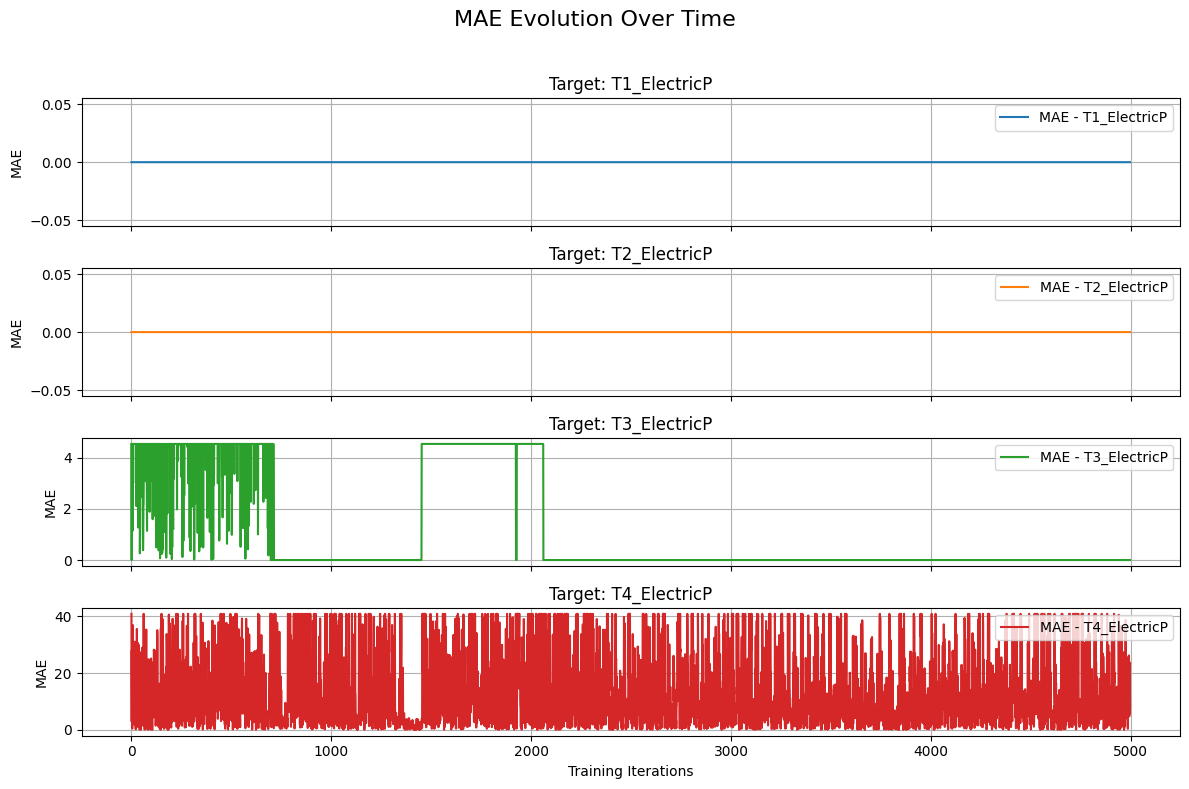

In [21]:
# Call the function after training
plot_mae_evolution_subplots(mae_history_snarimax, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

# Hoeffding Tree Regressor

In [22]:
# Initialize previous data list and processed indices set
previous_data = []
processed_indices = set()

# Initialize results dictionary to store prediction outcomes
results = {
    'T1_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T2_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T3_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []},
    'T4_ElectricP': {'timestamp': [], 'actual': [], 'predicted': []}
}

In [23]:
# Simulate streaming data processing
for index, row in data.tail(10000).iterrows():
  process_and_train_row(index, row, HoeffdingTreeModels, previous_data, processed_indices, results, mae_history_HTM)

Se han truncado las últimas 5000 líneas del flujo de salida.
Index: 744610, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 744610, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744610, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0042, MAE: 0.0014
Index: 744610, Target: T4_ElectricP, True: 372.9998, Predicted: 420.0378, MAE: 11.7606
Index: 744611, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 744611, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744611, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0042, MAE: 0.0014
Index: 744611, Target: T4_ElectricP, True: 390.9998, Predicted: 420.0226, MAE: 7.2568
Index: 744612, Target: T1_ElectricP, True: 1.0000, Predicted: 1.0000, MAE: 0.0000
Index: 744612, Target: T2_ElectricP, True: 0.0000, Predicted: 0.0000, MAE: 0.0000
Index: 744612, Target: T3_ElectricP, True: 0.0000, Predicted: 0.0042, MAE: 0.0014
Index: 744612, Target: T4_El

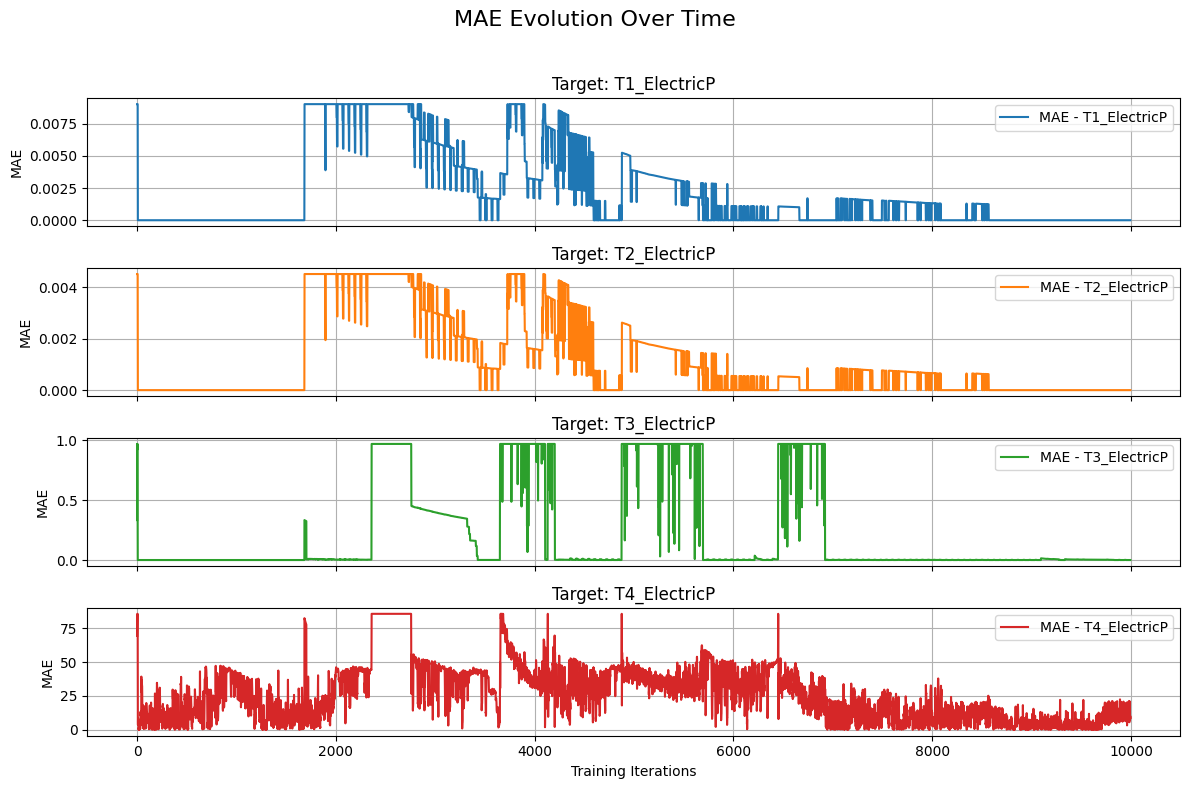

In [24]:
# Call the function after training
plot_mae_evolution_subplots(mae_history_HTM, targets=['T1_ElectricP', 'T2_ElectricP', 'T3_ElectricP', 'T4_ElectricP'])

# Models MAE Comparison

In [31]:
# Function to calculate average MAE for the last 1000 iterations
def calculate_average_mae(mae_history, last_values=-1000):
    return {key: np.mean(values[last_values:]) for key, values in mae_history.items()}

# Calculate average MAE for each model using the updated function
average_mae_LR = calculate_average_mae(mae_history_LR)
average_mae_snarimax = calculate_average_mae(mae_history_snarimax)
average_mae_HTM = calculate_average_mae(mae_history_HTM)

# Generate Markdown table with proper alignment
header = "| Target         | Linear Regression (LR) | SNARIMAX          | HTM               |"
divider = "|----------------|------------------------|-------------------|-------------------|"
rows = []
for target in mae_history_LR.keys():
    row = f"| {target:<14} | {average_mae_LR[target]:<22.4f} | {average_mae_snarimax[target]:<17.4f} | {average_mae_HTM[target]:<17.4f} |"
    rows.append(row)

# Combine header, divider, and rows into a Markdown table
markdown_table = header + "\n" + divider + "\n" + "\n".join(rows)

# Print the Markdown table
print(markdown_table)


| Target         | Linear Regression (LR) | SNARIMAX          | HTM               |
|----------------|------------------------|-------------------|-------------------|
| T1_ElectricP   | 0.0084                 | 0.0000            | 0.0000            |
| T2_ElectricP   | 0.0042                 | 0.0000            | 0.0000            |
| T3_ElectricP   | 0.0168                 | 0.0000            | 0.0034            |
| T4_ElectricP   | 7.1589                 | 13.1401           | 6.3070            |


In [32]:
# Function to calculate average MAE for the last 1000 iterations
def calculate_average_mae(mae_history, last_values=-1000):
    return {key: np.mean(values[last_values:]) for key, values in mae_history.items()}

# Calculate average MAE for each model using the updated function
average_mae_LR = calculate_average_mae(mae_history_LR, last_values=-5000)
average_mae_snarimax = calculate_average_mae(mae_history_snarimax, last_values=-5000)
average_mae_HTM = calculate_average_mae(mae_history_HTM, last_values=-5000)

# Generate Markdown table with proper alignment
header = "| Target         | Linear Regression (LR) | SNARIMAX          | HTM               |"
divider = "|----------------|------------------------|-------------------|-------------------|"
rows = []
for target in mae_history_LR.keys():
    row = f"| {target:<14} | {average_mae_LR[target]:<22.4f} | {average_mae_snarimax[target]:<17.4f} | {average_mae_HTM[target]:<17.4f} |"
    rows.append(row)

# Combine header, divider, and rows into a Markdown table
markdown_table = header + "\n" + divider + "\n" + "\n".join(rows)

# Print the Markdown table
print(markdown_table)


| Target         | Linear Regression (LR) | SNARIMAX          | HTM               |
|----------------|------------------------|-------------------|-------------------|
| T1_ElectricP   | 0.0081                 | 0.0002            | 0.0008            |
| T2_ElectricP   | 0.0040                 | 0.0000            | 0.0004            |
| T3_ElectricP   | 77.1598                | 73047.7427        | 2.8286            |
| T4_ElectricP   | 69.9535                | 13.1258           | 18.9155           |
